In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from scipy.stats import norm
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

import re
import unidecode

from sklearn import preprocessing
from sklearn import ensemble
from sklearn import linear_model

from sklearn.linear_model import LogisticRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import normalize, StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.decomposition import PCA, TruncatedSVD


# Plot formatting: 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'



# Wine Reviews
https://www.kaggle.com/zynicide/wine-reviews

## The practical uses of this model:
- Audience of interest:
    - Wine sellers
    - Wine consumers
- Predicting wine prices could help wine distributors price their inventory more competitively 
- Predicting wine prices could also help consumers make more educated purchasing decisions, whether they should pay a particular price for a certain wine 
- Predicting wine ratings could potentially help winemakers focus on certain aspects of the winemaking process to ensure that the wines express certain characteristics that would lead to a higher point rating
- Predicting wine ratings could also identify the relevant characteristics of wine that make it good or great

## Dataset information: 
- **country**:  The country that the wine is from
- description: A few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.
- **description**: A few sentences from a sommelier describing the wine's taste, smell, look, feel, etc
- **designation**: The vineyard within the winery where the grapes that made the wine are from
- **points**: The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for wines that score >=80)
- **price**: The cost for a bottle of the wine
- **province**: The province or state that the wine is from
- **region_1**: The wine growing area in a province or state (ie Napa)
- **region_2**: Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this value can sometimes be blank
- **variety**: The type of grapes used to make the wine (ie Pinot Noir)
- **winery**: The winery that made the wine

## Limitations/Unavailable Data:

Percent alcohol by volume is ubiquitous information on wine labels, but it is missing from this dataset.

The "points" ratings in this set are all between 80 and 100 points.

Lastly, the ratings are all subjective, as are the individual descriptions by the sommeliers.

 ## Overview: 
 
This dataset was scraped from Wine Enthusiast by Zach Thoutt, and posted on Kaggle. My goal is to create models that will try to predict the price of of a bottle of wine or the points rating of a wine, based on wine review data. 

In [2]:
df = pd.read_csv('winemag-data_first150k.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
Unnamed: 0     150930 non-null int64
country        150925 non-null object
description    150930 non-null object
designation    105195 non-null object
points         150930 non-null int64
price          137235 non-null float64
province       150925 non-null object
region_1       125870 non-null object
region_2       60953 non-null object
variety        150930 non-null object
winery         150930 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


`region_2` will be excluded from the dataset as most of the values are missing

In [3]:
df = df.drop([ 'region_2', 'Unnamed: 0'], axis=1)
df.head()

,country,description,designation,points,price,province,region_1,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,Provence red blend,Domaine de la Bégude


In [4]:
# Dropping duplicates and null values:
df = df[df.duplicated('description', keep=False)]
# df = df.dropna(subset=['description', 'points'])
print(len(df))

92393


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92393 entries, 25 to 150929
Data columns (total 9 columns):
country        92390 non-null object
description    92393 non-null object
designation    64625 non-null object
points         92393 non-null int64
price          83948 non-null float64
province       92390 non-null object
region_1       76535 non-null object
variety        92393 non-null object
winery         92393 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 7.0+ MB


In [6]:
# Missingness:

df.isnull().sum()/df.shape[0]


country        0.000032
description    0.000000
designation    0.300542
points         0.000000
price          0.091403
province       0.000032
region_1       0.171636
variety        0.000000
winery         0.000000
dtype: float64

In [7]:
# Fill in "NaN" values for "designation" and "region_1" and "province" columns:

df['designation'] = df['designation'].fillna('None')
df['region_1'] = df['region_1'].fillna('None')
df['province'] = df['province'].fillna('None')

# Dropping na rows because we cannot impute values for price, a target variable:
df = df.dropna()
df = df.reset_index(drop=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83945 entries, 0 to 83944
Data columns (total 9 columns):
country        83945 non-null object
description    83945 non-null object
designation    83945 non-null object
points         83945 non-null int64
price          83945 non-null float64
province       83945 non-null object
region_1       83945 non-null object
variety        83945 non-null object
winery         83945 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 5.8+ MB


In [9]:
# Getting a snapshot of the unique values in our dataset:
df.nunique()

country           41
description    35820
designation    13998
points            21
price            255
province         352
region_1         947
variety          442
winery          8440
dtype: int64

## Exploratory Data Analysis:
### Looking at our target variable distributions first:

#### Points: 


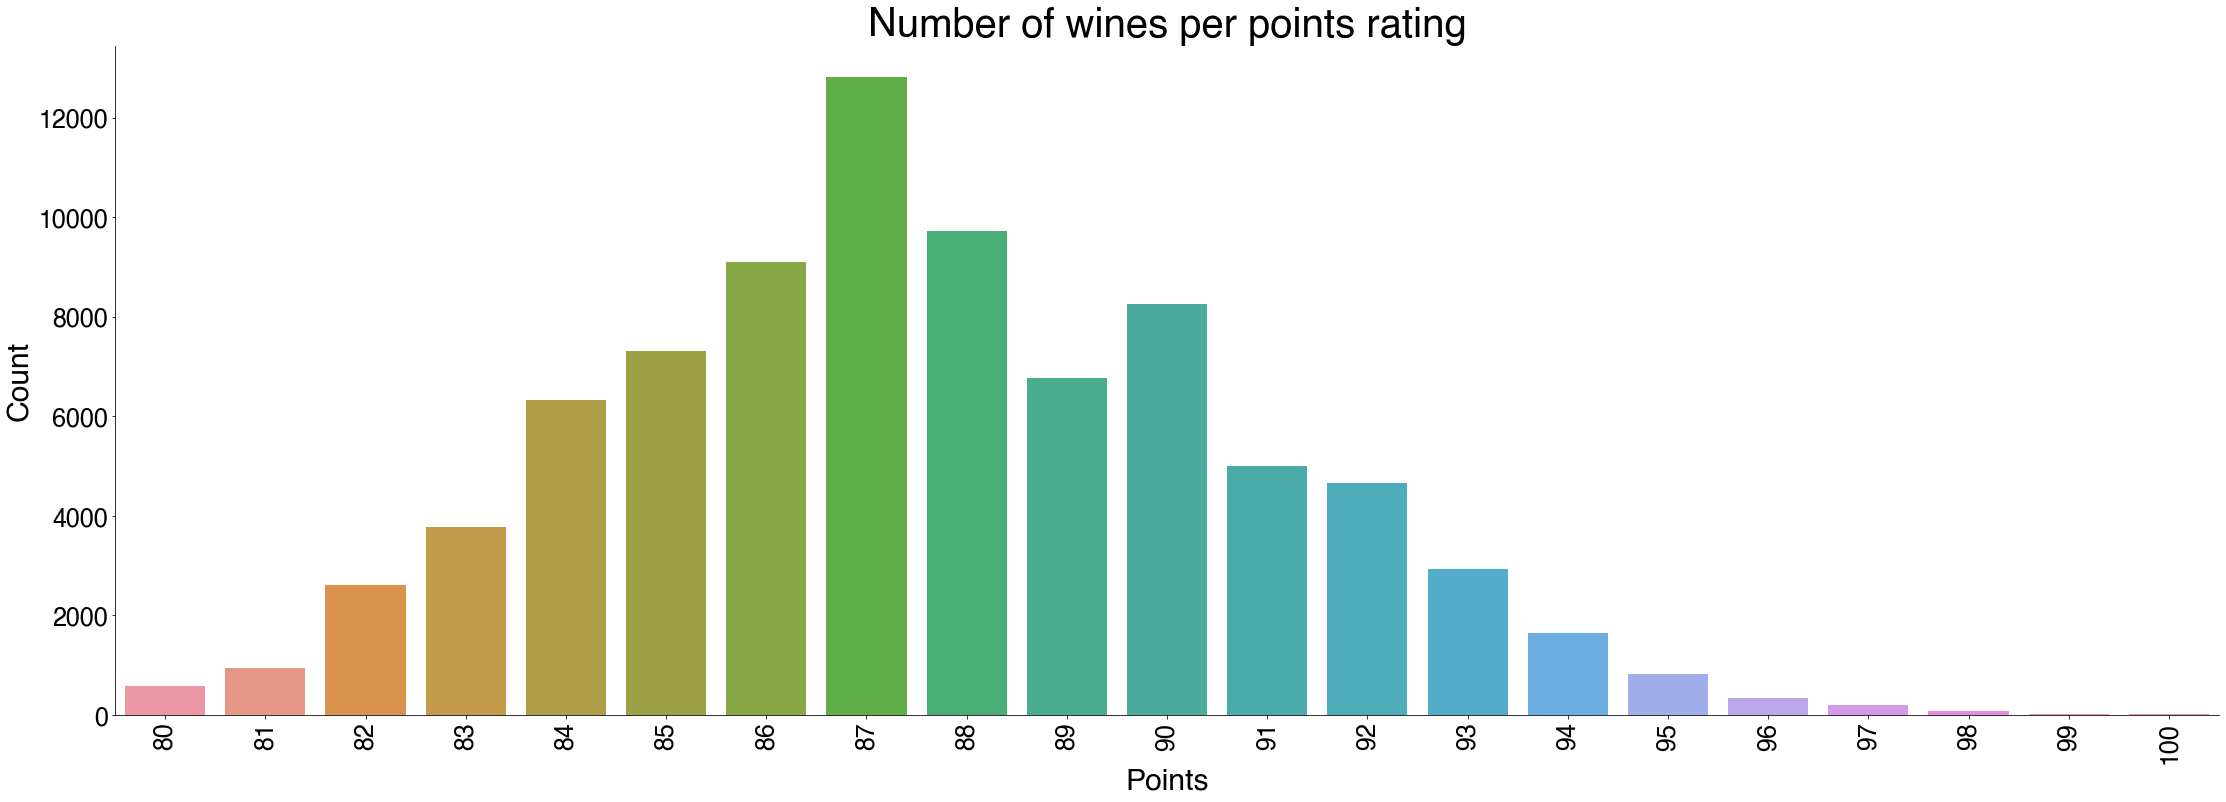

In [10]:
g = sns.catplot('points', data=df, kind='count', height=10, aspect=3)
g.set_xticklabels(rotation=90)
plt.xticks(fontsize=25) # X Ticks
plt.yticks(fontsize=25) # Y Ticks
plt.title('Number of wines per points rating', fontsize=40, fontweight="bold")
plt.ylabel('Count', fontsize= 30)
plt.xlabel('Points', fontsize=30)
plt.show()

Looks like most of the wines are rated in the 83-93 range, with a somewhat normal looking distribution.
Since this dataset only has the positively reviewed wines, the range for the ratings is between 80-100.

#### Wine Prices:

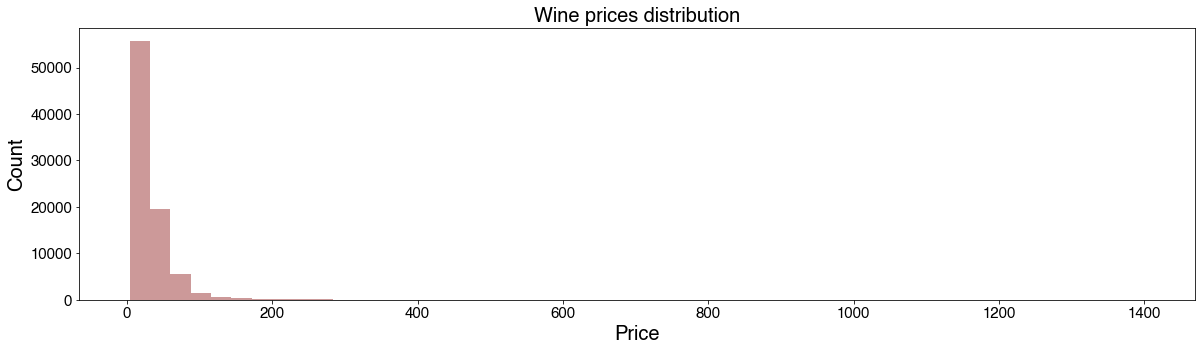

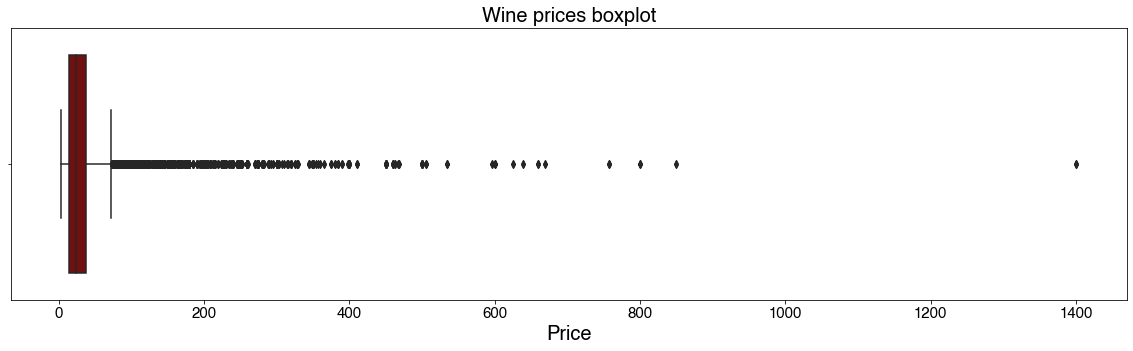

In [11]:
plt.figure(figsize=(20,5))

sns.distplot(df.price, kde=False, color='maroon')

plt.xticks(fontsize=15) # X Ticks
plt.yticks(fontsize=15) # Y Ticks
plt.title('Wine prices distribution', fontsize=20, fontweight="bold")
plt.ylabel('Count', fontsize= 20)
plt.xlabel('Price', fontsize=20)
plt.show()

plt.figure(figsize=(20,5))

sns.boxplot(df.price, color='maroon')

plt.xticks(fontsize=15) # X Ticks
plt.yticks(fontsize=15) # Y Ticks
plt.title('Wine prices boxplot', fontsize=20, fontweight="bold")

plt.xlabel('Price', fontsize=20)
plt.show()


In [12]:
df.describe()

,points,price
count,83945.000000,83945.000000
mean,87.631485,32.064590
std,3.201676,33.255466
min,80.000000,4.000000
25%,85.000000,15.000000
50%,87.000000,24.000000
75%,90.000000,38.000000
max,100.000000,1400.000000


Looking at the wine prices, its very clear that the data is heavily skewed right and has outliers. The mean price is 32 with a standard deviation of 33, but there are prices up to 1400 dollars a bottle.

### Outlier removal:
- Removing the 1400 dollar wine

In [13]:
df = df[df.price < 1000]
df = df.reset_index(drop=True)

#### Visualizing Price vs points

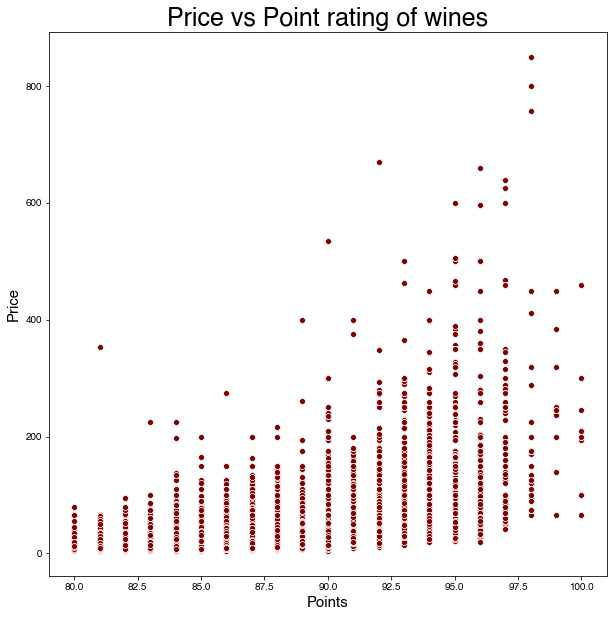

In [14]:
plt.figure(figsize=(10,10))

sns.scatterplot(x='points', y='price', data=df, color="maroon")
plt.title("Price vs Point rating of wines", fontsize=25)
plt.xlabel('Points', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.show()

Wine prices and points dont seem to exhibit a strong correlation, although there is a slight trend for higher rated wines to be more expensive. 

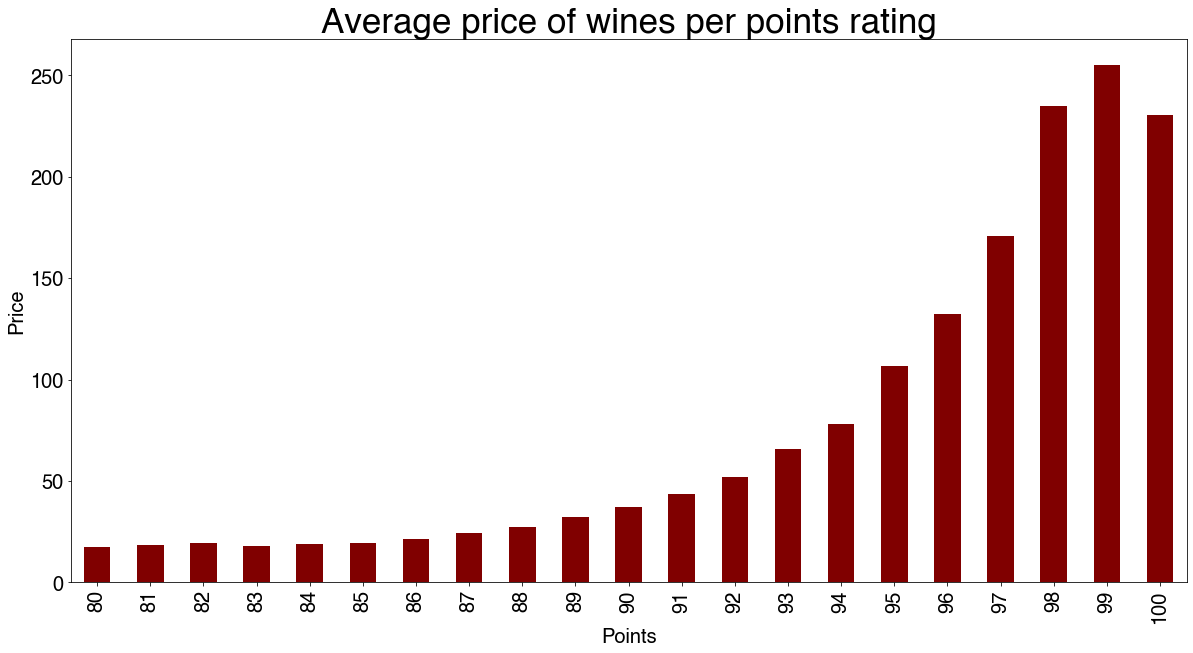

In [15]:
plt.figure(figsize=(20,10))

df.groupby('points').price.mean().plot(kind="bar",color="maroon")
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
plt.title('Average price of wines per points rating', fontweight="bold", size=35) # Title
plt.xlabel('Points', fontsize=20)
plt.ylabel('Price', fontsize = 20)
plt.show()

Interesting to see, is that the prices for wines are relatively the same for wines that are rated under 90. Above 90 points, there is a increasingly large difference in the price of a wine for each additional point rating. 

### Variable exploration: country
- There are 41 countries in represented in this dataset, here we explore them

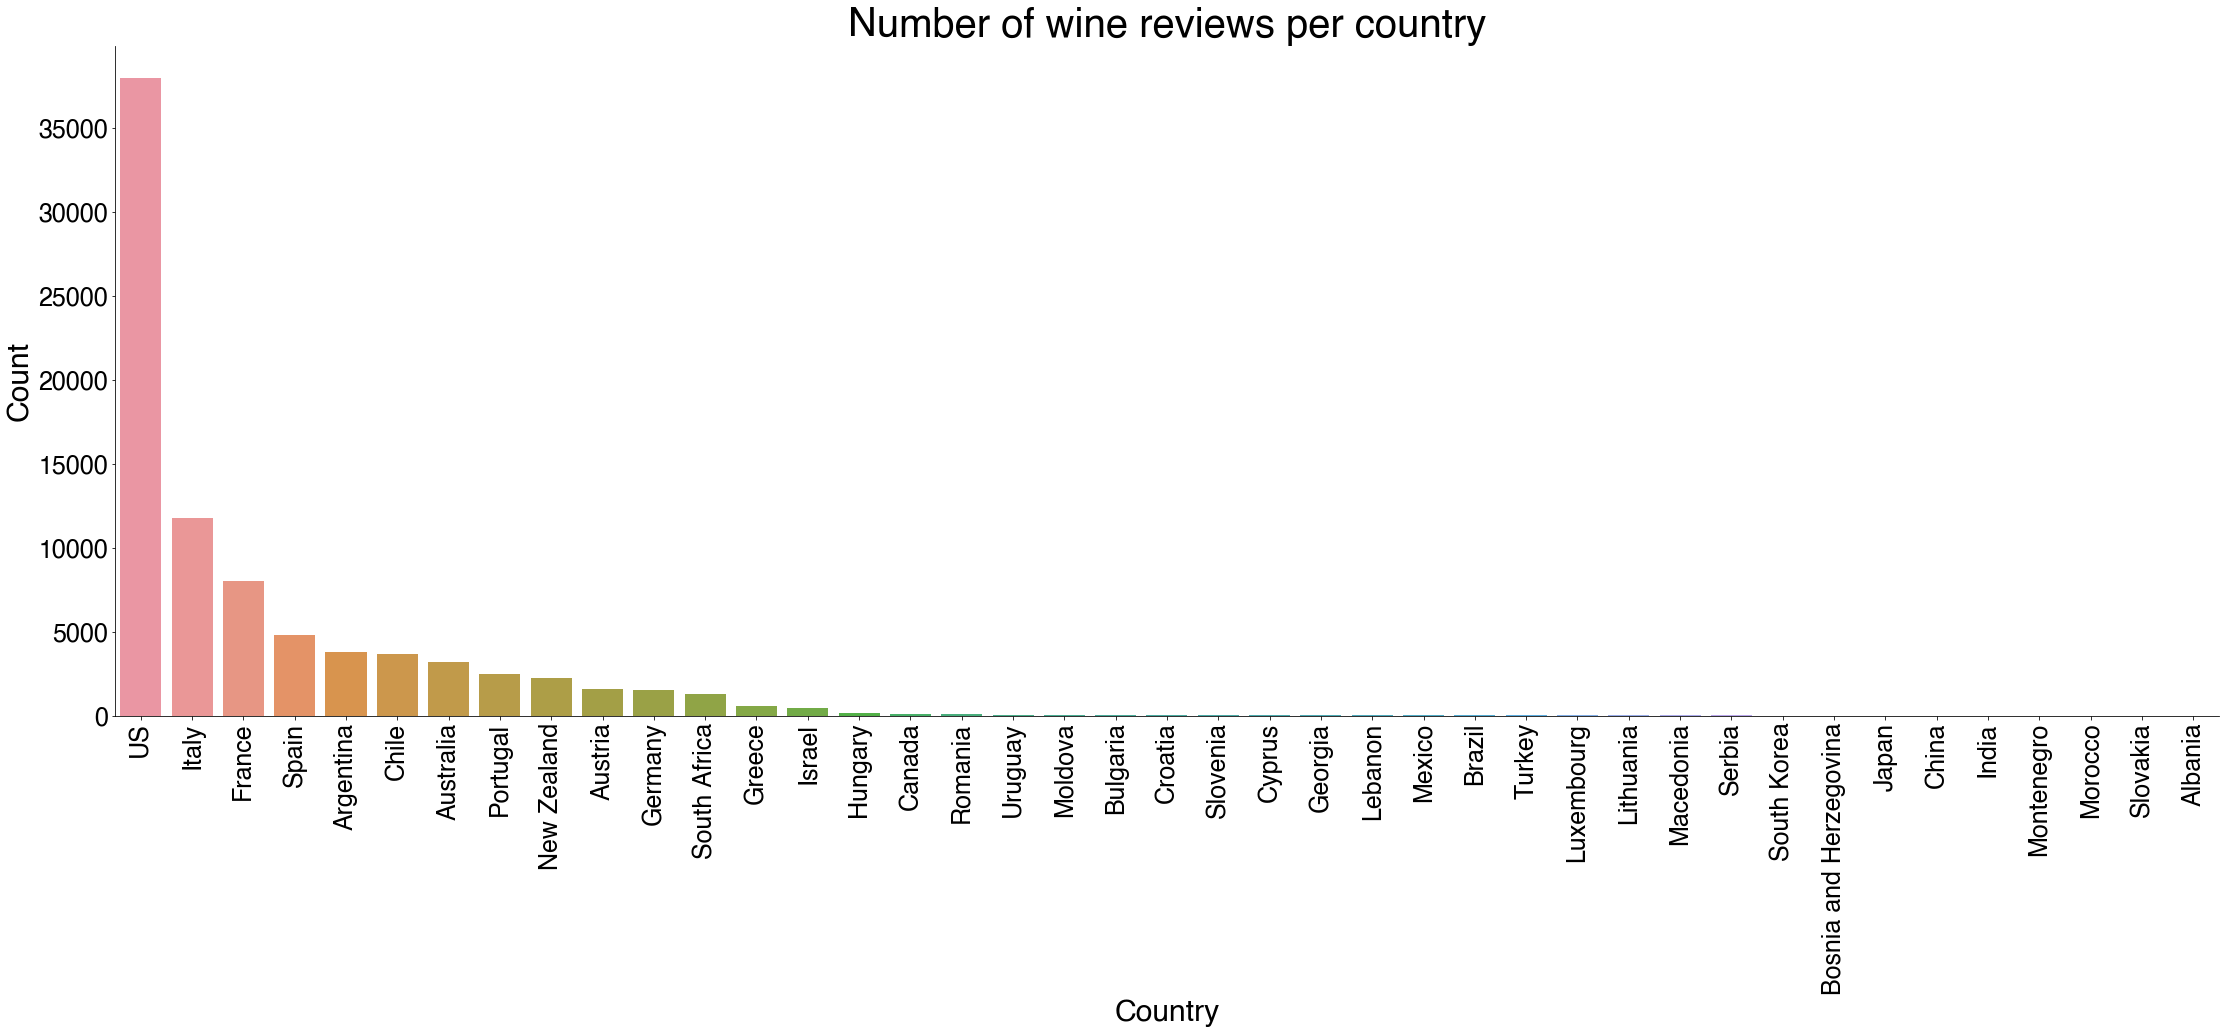

In [16]:
g = sns.catplot('country', data=df, kind='count', height=10, aspect=3, 
                order=df.groupby("country").points.count().sort_values(ascending=False).index
               )
g.set_xticklabels(rotation=90)
plt.xticks(fontsize=25) # X Ticks
plt.yticks(fontsize=25) # Y Ticks
plt.title('Number of wine reviews per country', fontsize=40, fontweight="bold")
plt.ylabel('Count', fontsize= 30)
plt.xlabel('Country', fontsize=30)
plt.show()

In [17]:
df.country.value_counts(normalize=True).head(10)*100

US             45.215744
Italy          14.000143
France          9.518477
Spain           5.739677
Argentina       4.503109
Chile           4.338710
Australia       3.766887
Portugal        2.967525
New Zealand     2.675657
Austria         1.854852
Name: country, dtype: float64

Looks like this dataset is dominated by wines from the US, making up 45% of the dataset, followed by Italy, France, Spain, Argentina, and Chile. 

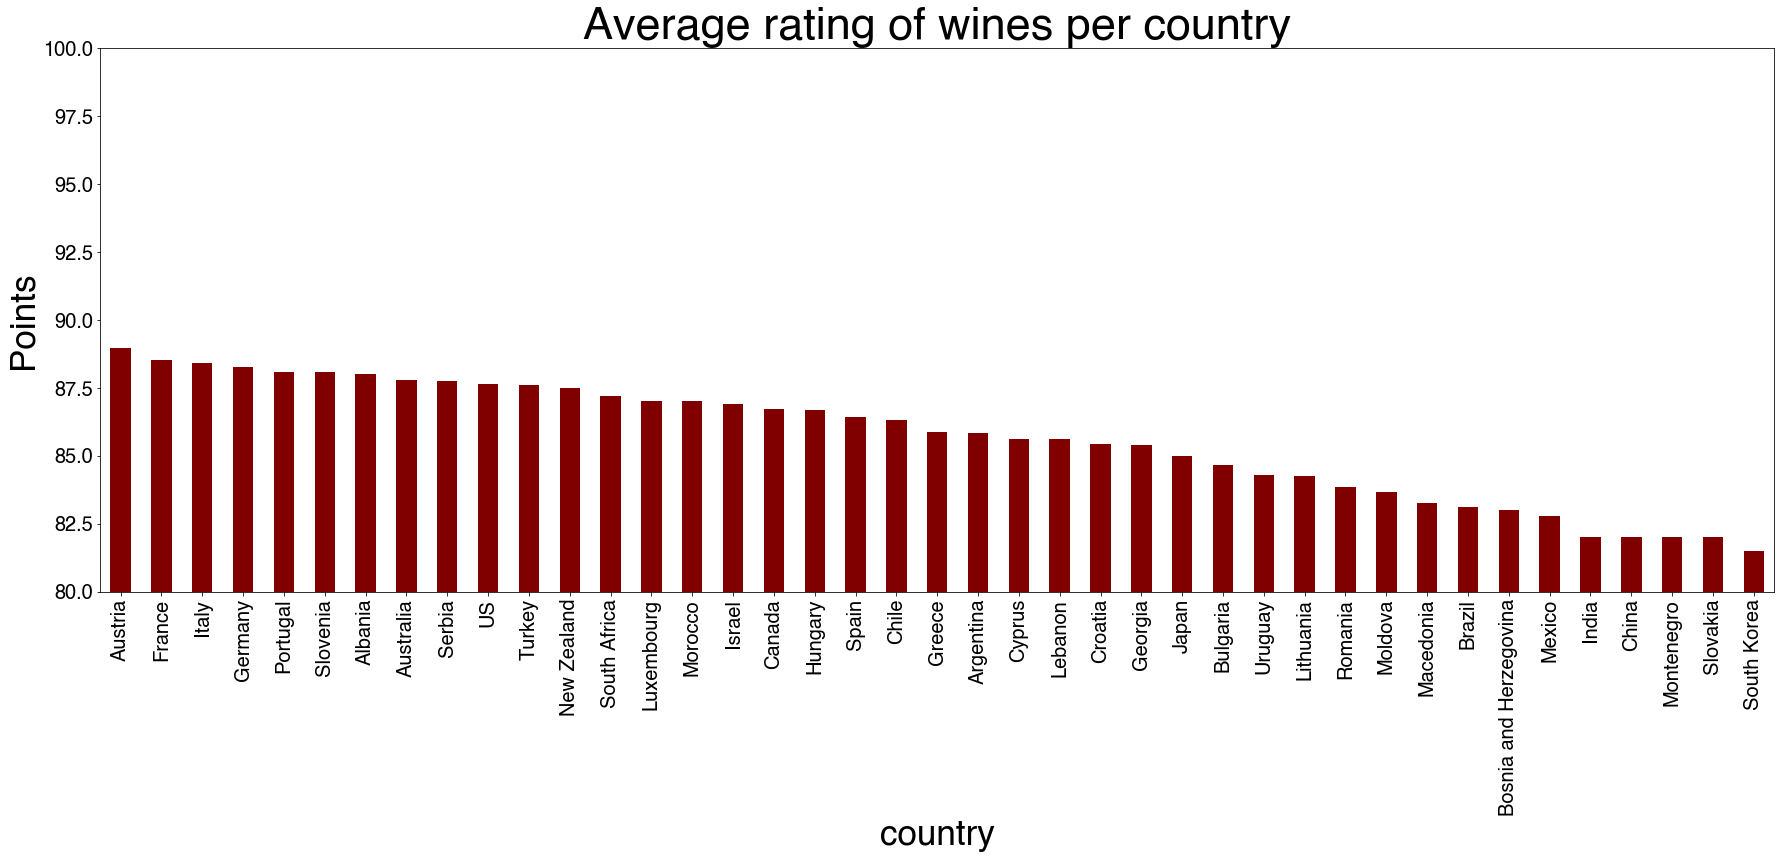

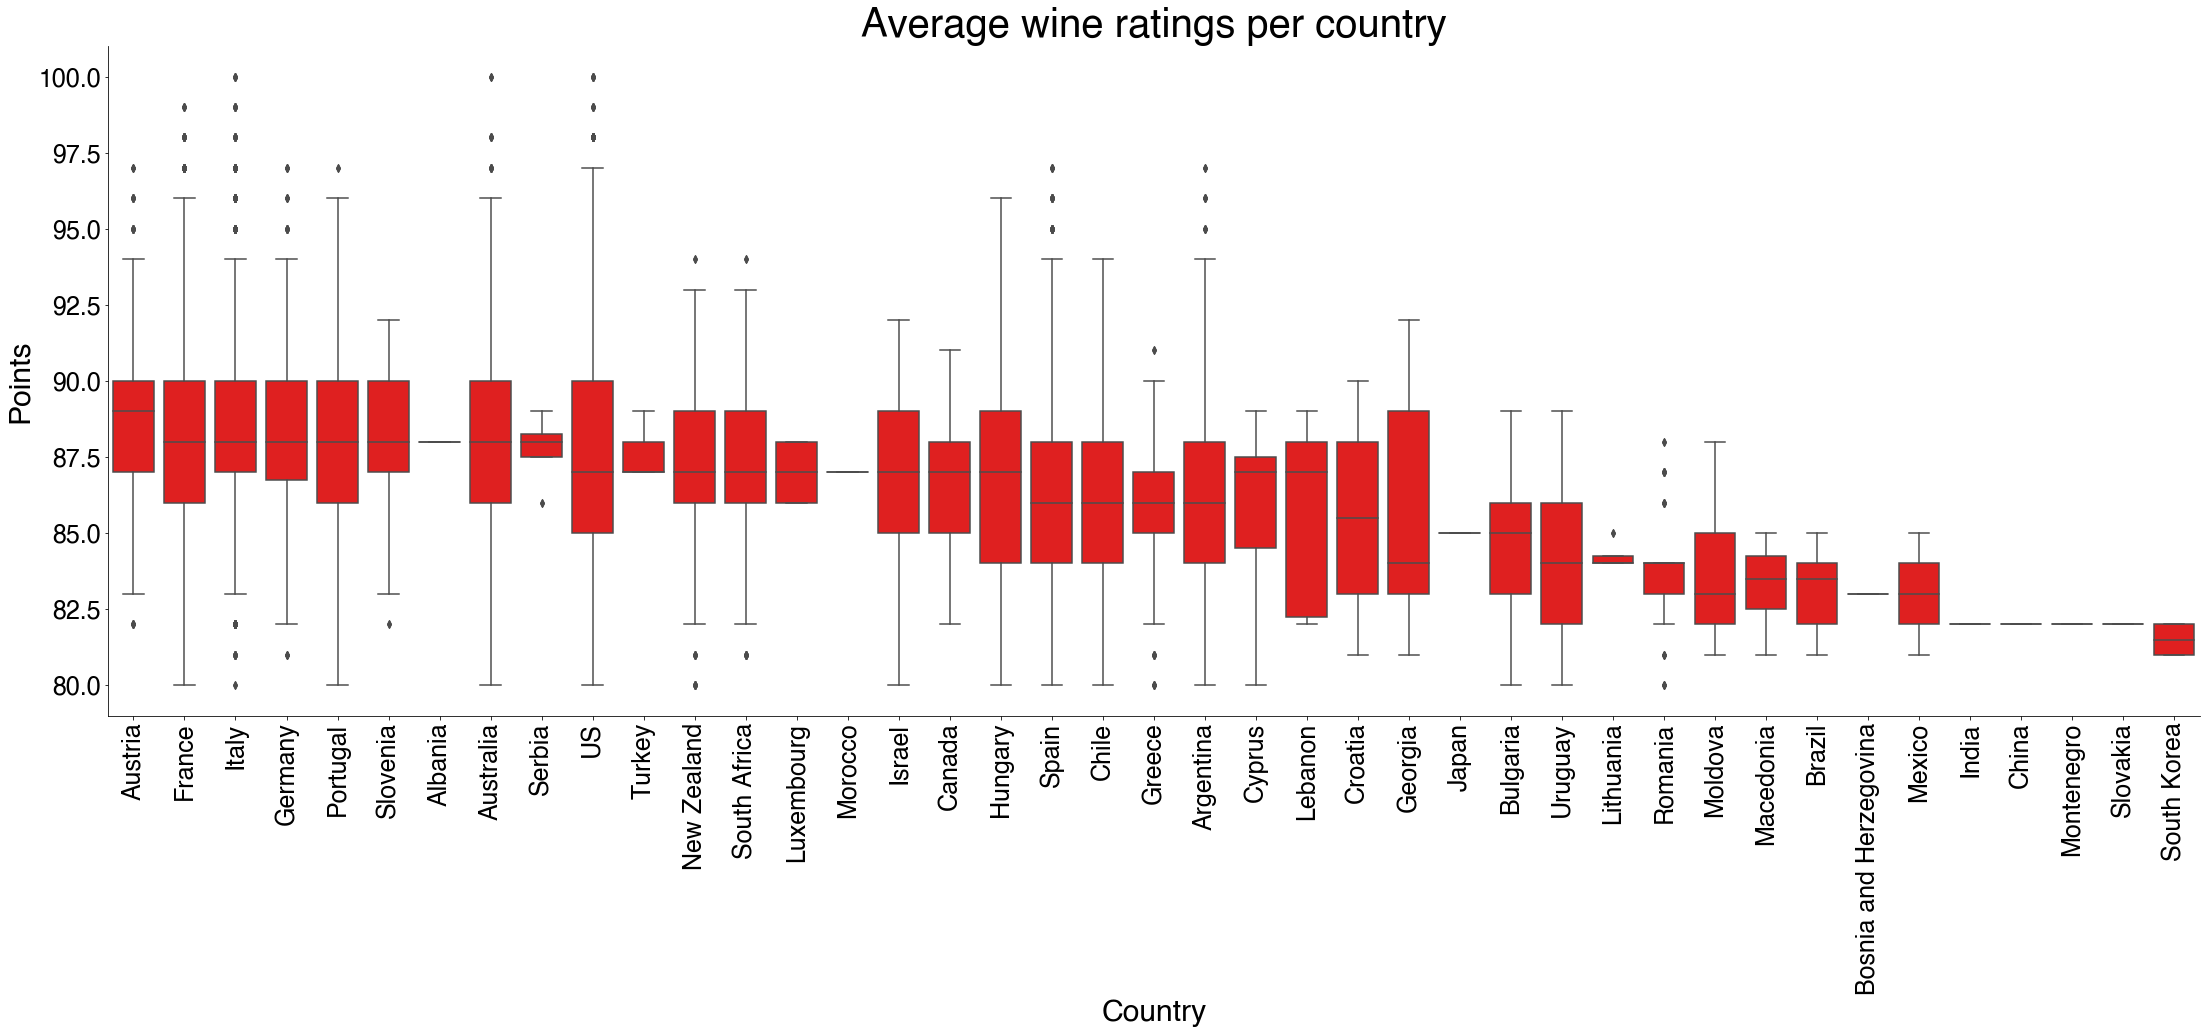

Average points rating by country (top 10): 
country
Austria      88.973667
France       88.536421
Italy        88.392954
Germany      88.247333
Portugal     88.081493
Slovenia     88.064516
Albania      88.000000
Australia    87.796648
Serbia       87.750000
US           87.641022
Name: points, dtype: float64


In [18]:
# Plotting mean points rating for the countries in the dataset
fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Average rating of wines per country', fontweight="bold", size=45) # Title
ax.set_ylabel('Points', fontsize = 35) # Y label
ax.set_xlabel('Country', fontsize = 35) # X label

df.groupby(['country']).points.mean().sort_values(ascending=False).plot(ax=ax, kind='bar', color='maroon')
plt.ylim((80, 100)) 
plt.show()

# Boxplot of the average ratings per country: 

g = sns.catplot('country', 'points', data=df, kind='box', height=10, aspect=3, 
                order=df.groupby('country').points.mean().sort_values(ascending=False).index,
                color='red')
g.set_xticklabels(rotation=90)
plt.xticks(fontsize=25) # X Ticks
plt.yticks(fontsize=25) # Y Ticks
plt.title('Average wine ratings per country', fontsize=40, fontweight="bold")
plt.ylabel('Points', fontsize= 30)
plt.xlabel('Country', fontsize=30)
plt.show()

print('Average points rating by country (top 10): ')
print(df.groupby('country').points.mean().sort_values(ascending=False).head(10))

Despite having the most amount of wines, the US doesnt seem to have the highest rated wines on average. Wines from Austria have the highest average score, but wines from the US seem to have the greatest spread of points.

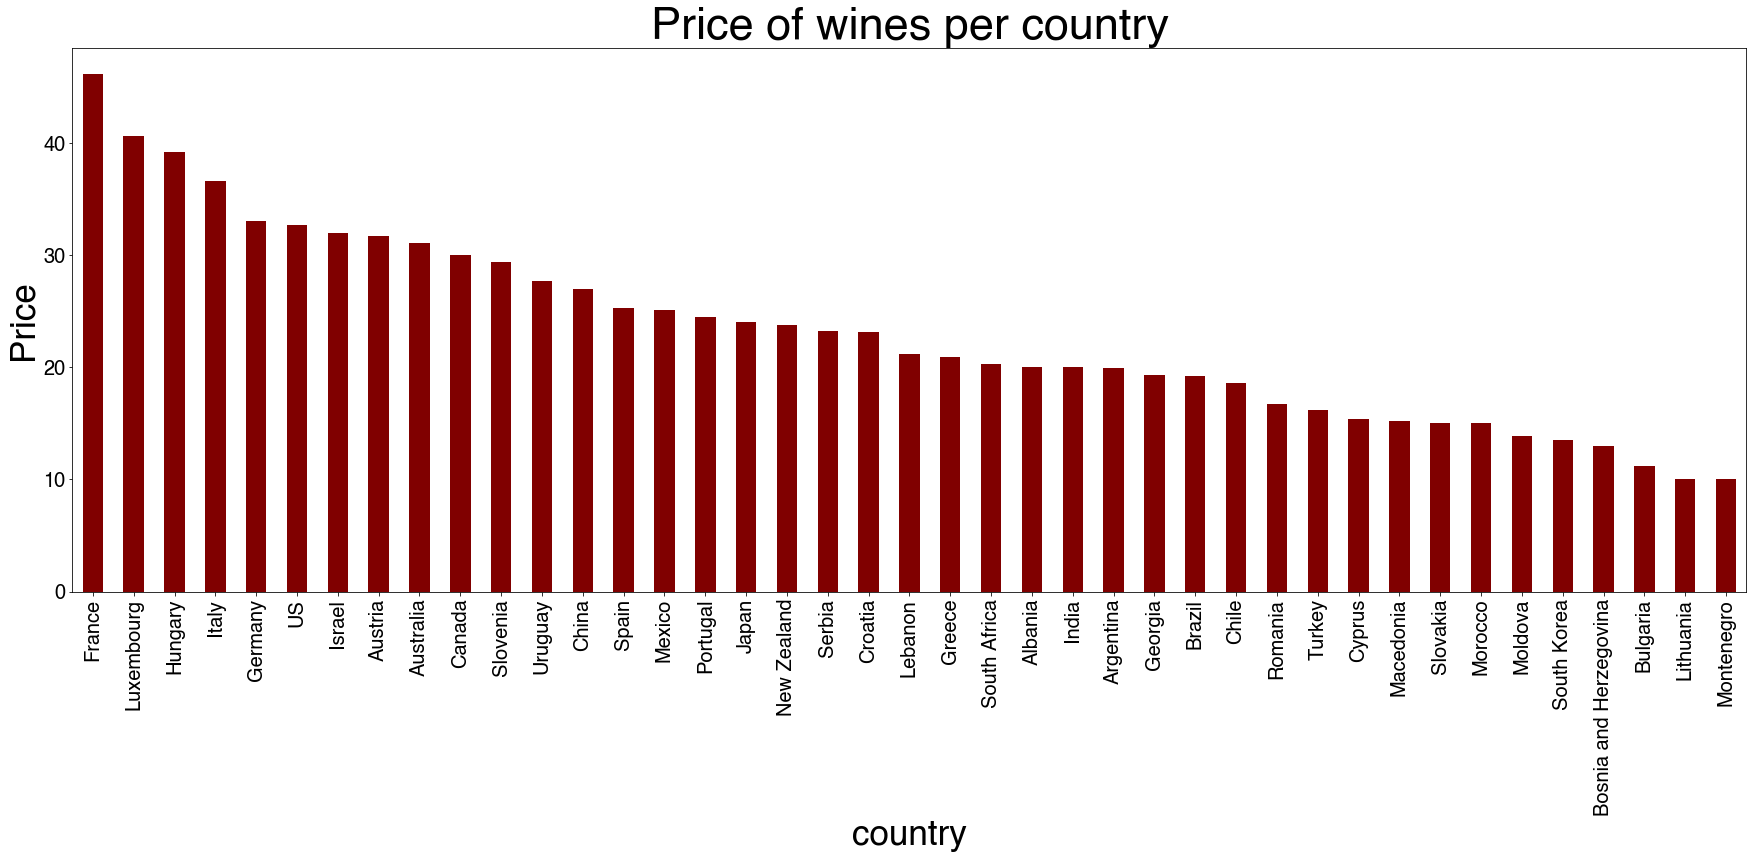

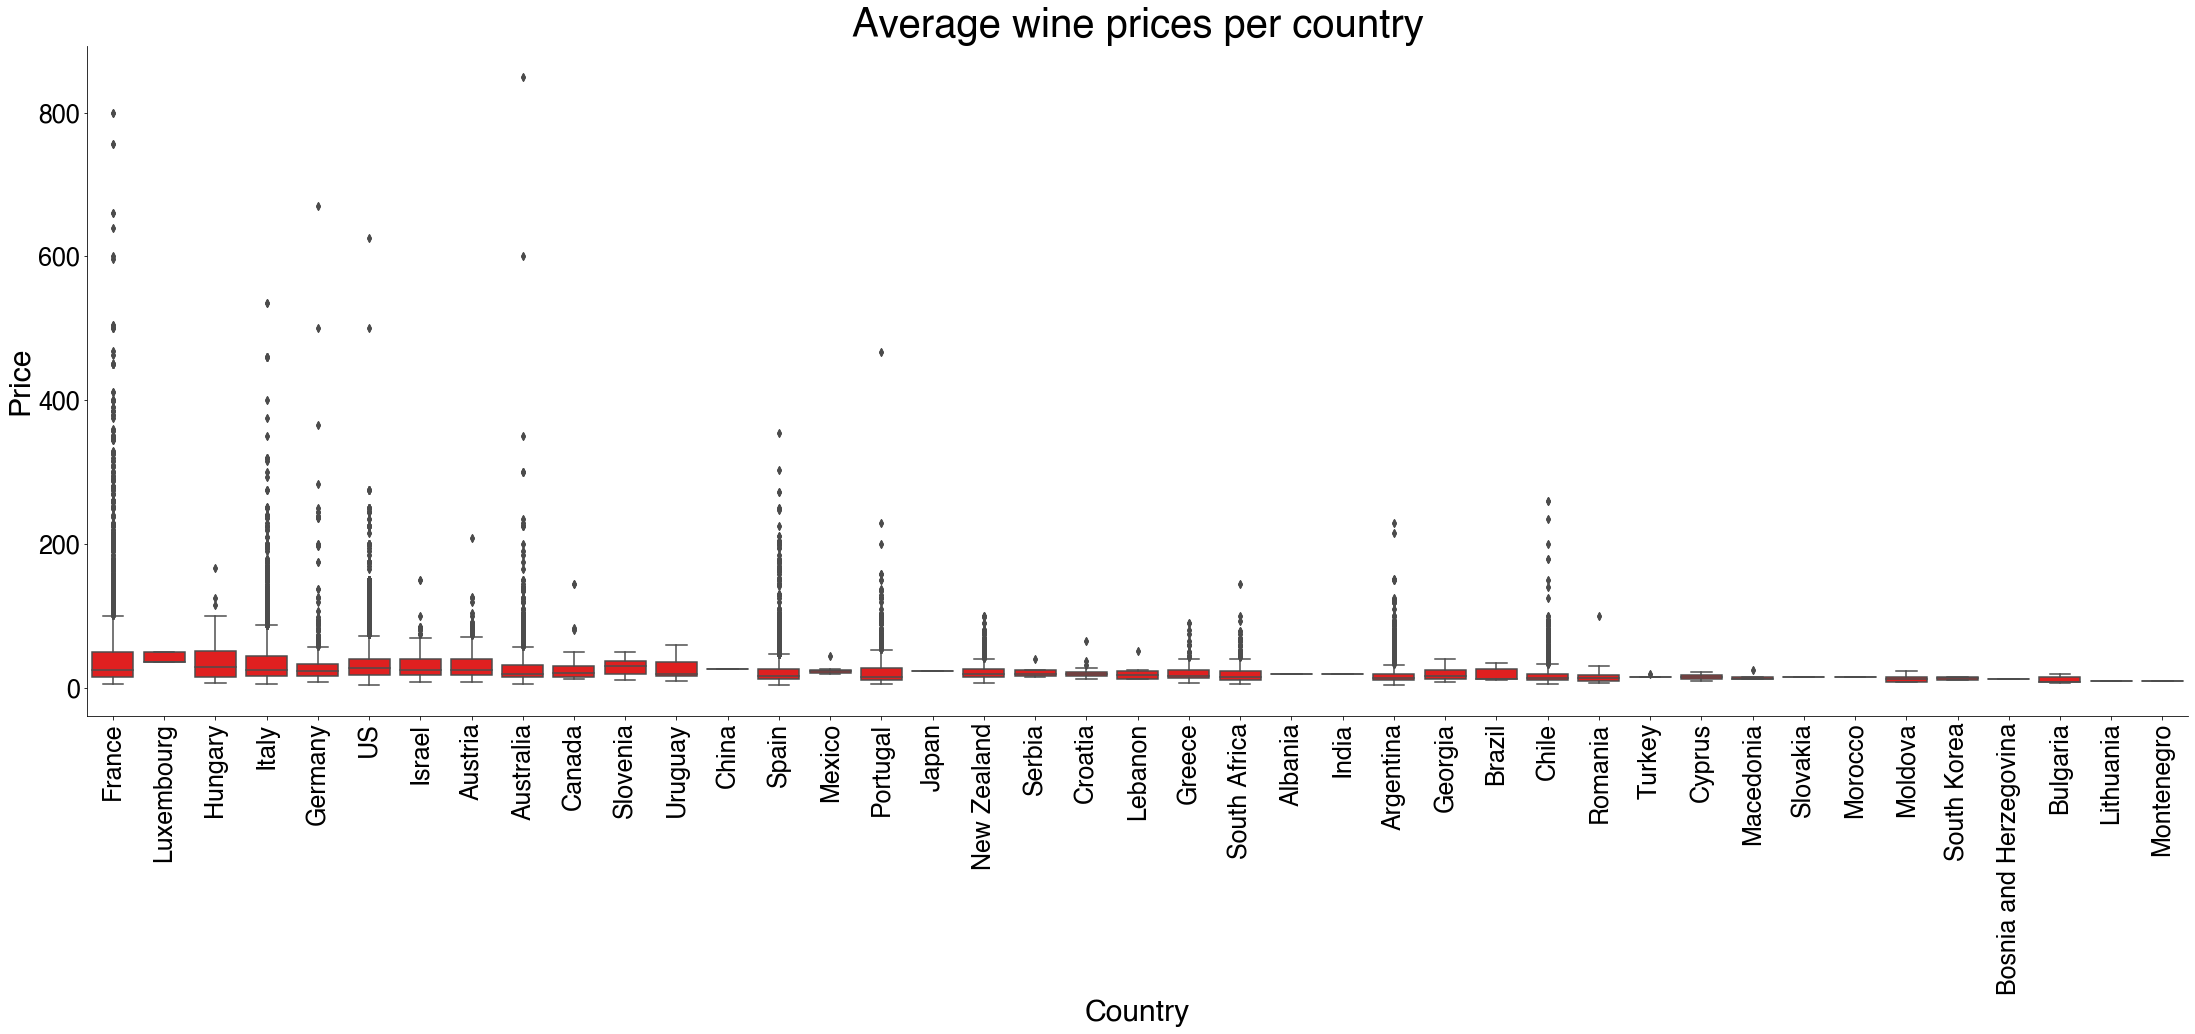

Average price of a wine bottle by country (top 10): 
country
France        46.168461
Luxembourg    40.666667
Hungary       39.173410
Italy         36.616576
Germany       33.028667
US            32.686207
Israel        31.973913
Austria       31.694284
Australia     31.055345
Canada        29.975904
Name: price, dtype: float64


In [19]:

# Plotting the average price of a wine bottle per country:
fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Price of wines per country', fontweight="bold", size=45) # Title
ax.set_ylabel('Price', fontsize = 35) # Y label
ax.set_xlabel('Variety', fontsize = 35) # X label

df.groupby('country').price.mean().sort_values(ascending=False).head(50).plot(kind='bar', color='maroon')
plt.show()

# Boxplot of average prices of wine per country:
g = sns.catplot('country', 'price', data=df, kind='box', height=10, aspect=3, 
                order=df.groupby('country').price.mean().sort_values(ascending=False).index,
                color='red')
g.set_xticklabels(rotation=90)
plt.xticks(fontsize=25) # X Ticks
plt.yticks(fontsize=25) # Y Ticks
plt.title('Average wine prices per country', fontsize=40, fontweight="bold")
plt.ylabel('Price', fontsize= 30)
plt.xlabel('Country', fontsize=30)
plt.show()

print('Average price of a wine bottle by country (top 10): ')
print(df.groupby('country').price.mean().sort_values(ascending=False).head(10))

French wine seems to be the most expensive wine, coming in at 46 dollars a bottle on average.

### Variable exploration: Province

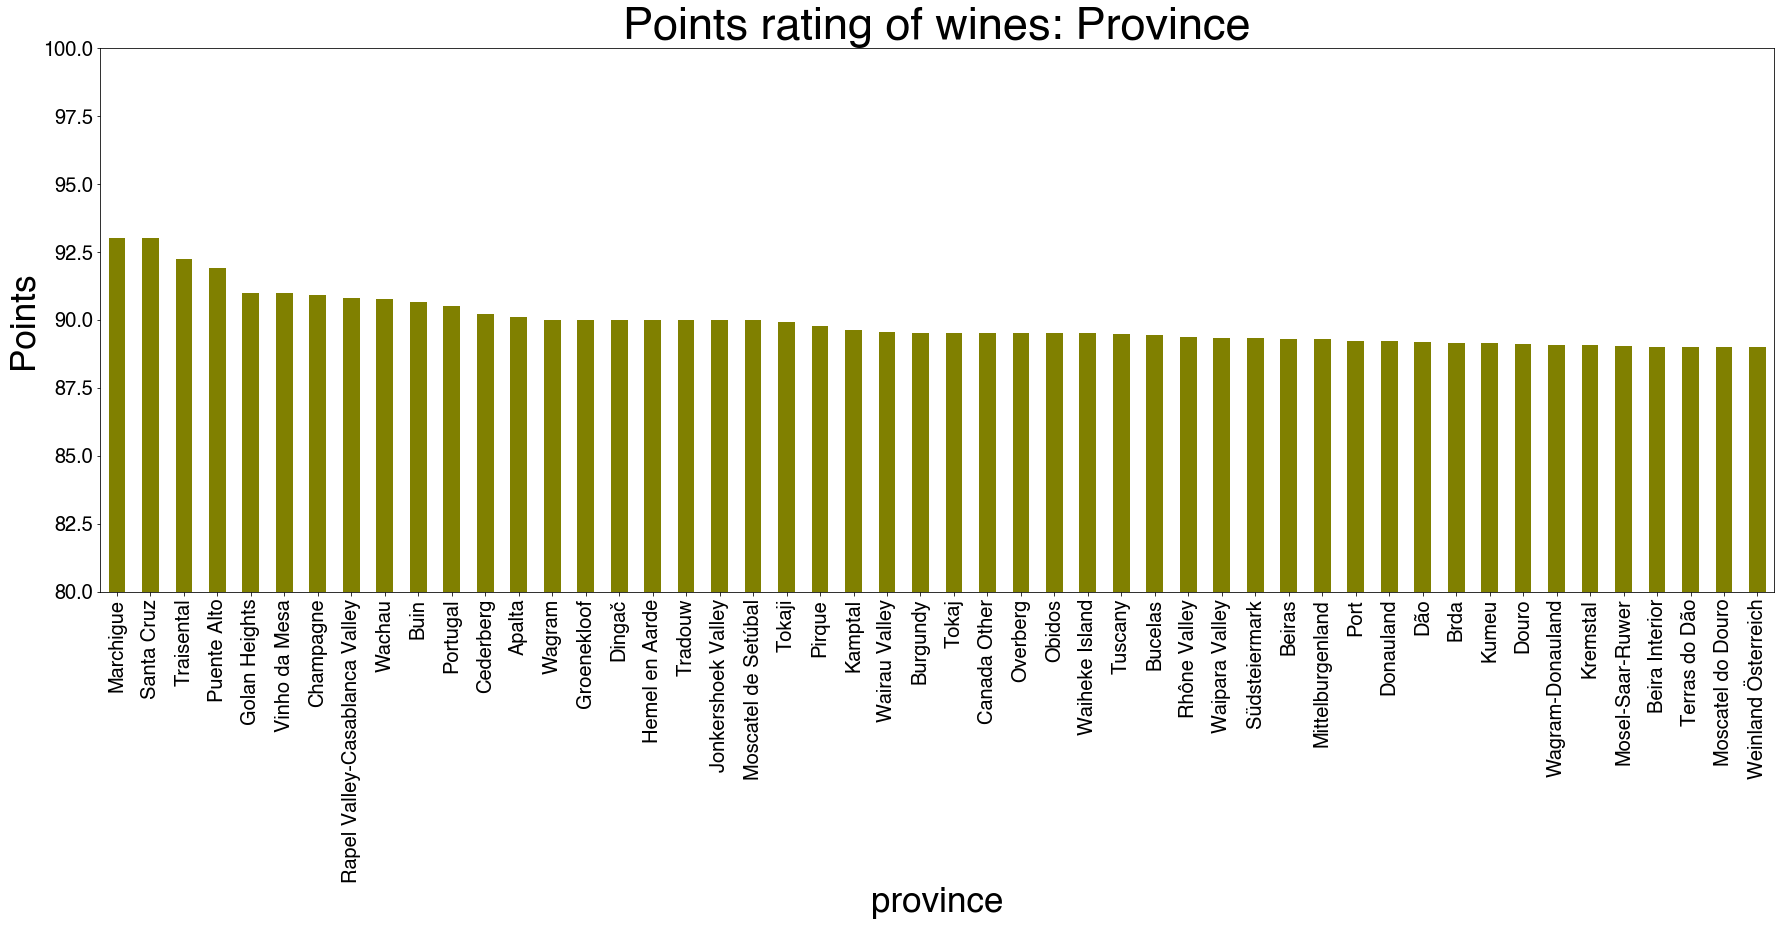

Average rating of wine by province (top 10): 
province
Marchigue                         93.000000
Santa Cruz                        93.000000
Traisental                        92.250000
Puente Alto                       91.923077
Golan Heights                     91.000000
Vinho da Mesa                     91.000000
Champagne                         90.900673
Rapel Valley-Casablanca Valley    90.800000
Wachau                            90.759434
Buin                              90.666667
Name: points, dtype: float64


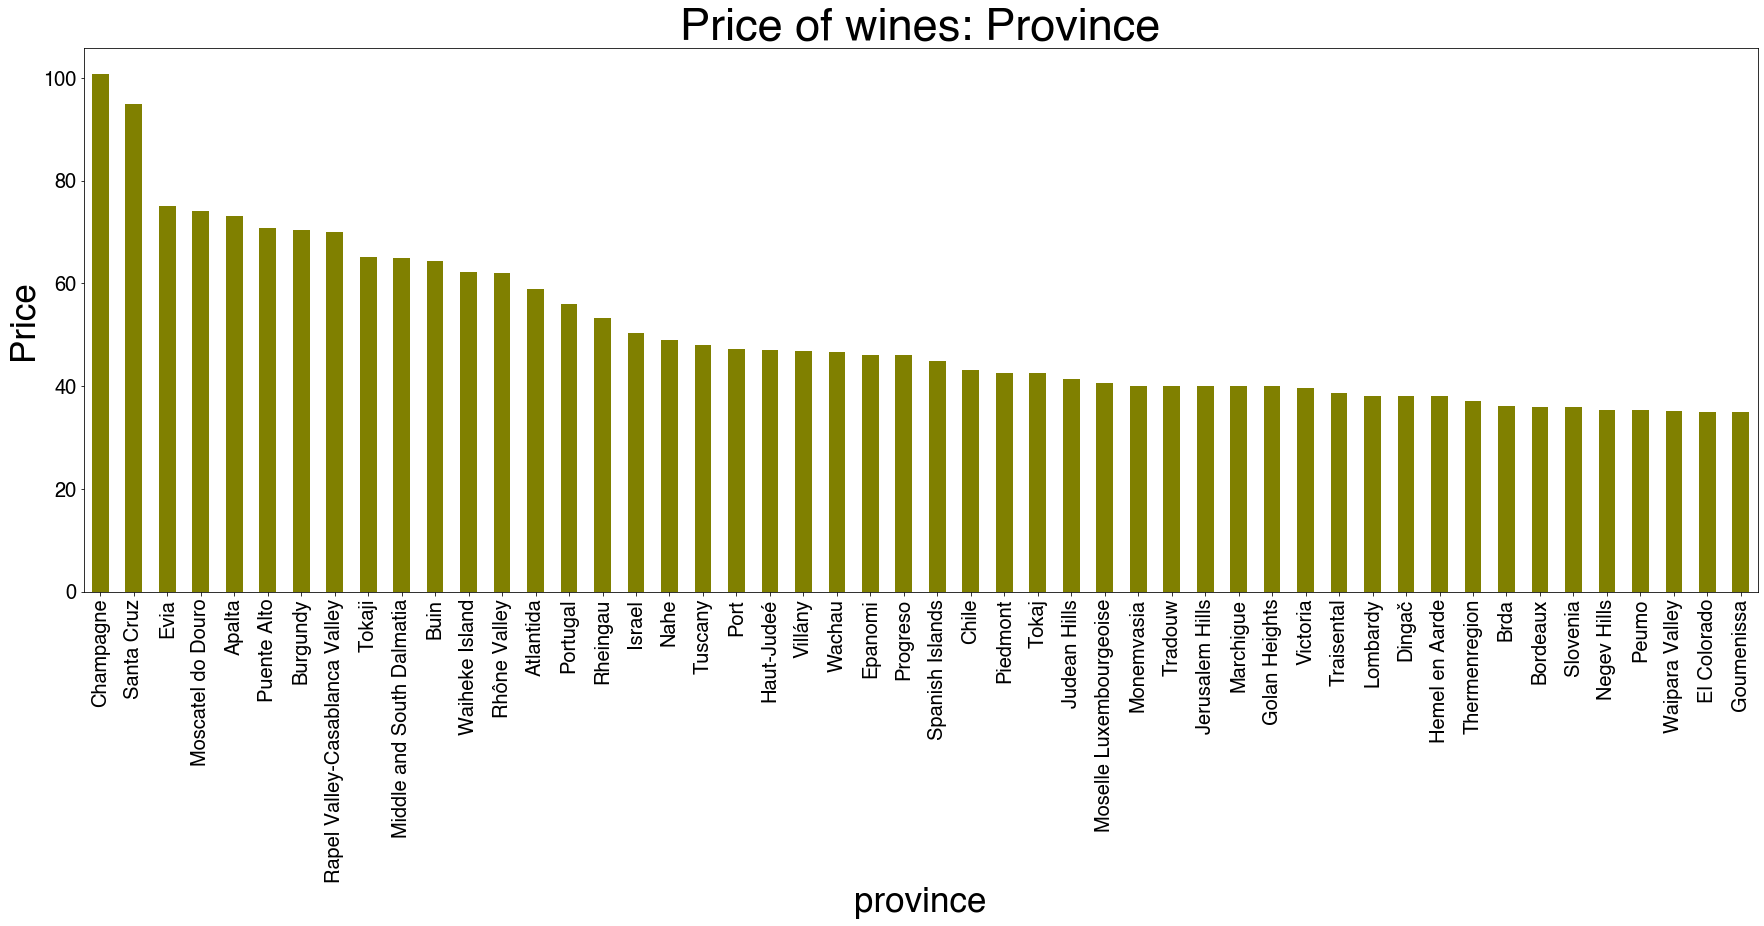

Average prices of wine by province (top 10): 
province
Champagne                         100.764310
Santa Cruz                         95.000000
Evia                               75.000000
Moscatel do Douro                  74.000000
Apalta                             73.111111
Puente Alto                        70.846154
Burgundy                           70.445658
Rapel Valley-Casablanca Valley     70.000000
Tokaji                             65.155556
Middle and South Dalmatia          65.000000
Name: price, dtype: float64


In [20]:
fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Points rating of wines: Province', fontweight="bold", size=45) # Title
ax.set_ylabel('Points', fontsize = 35) # Y label
ax.set_xlabel('Variety', fontsize = 35) # X label
plt.ylim((80, 100)) 

df.groupby('province').points.mean().sort_values(ascending=False).head(50).plot(kind='bar', color='olive')
plt.show()
print('Average rating of wine by province (top 10): ')
print(df.groupby('province').points.mean().sort_values(ascending=False).head(10))

fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Price of wines: Province', fontweight="bold", size=45) # Title
ax.set_ylabel('Price', fontsize = 35) # Y label
ax.set_xlabel('Variety', fontsize = 35) # X label

df.groupby('province').price.mean().sort_values(ascending=False).head(50).plot(kind='bar', color='olive')
plt.show()
print('Average prices of wine by province (top 10): ')
print(df.groupby('province').price.mean().sort_values(ascending=False).head(10))

Another interesting observation, 3 of the top 4 highest rated provinces for wine are in Chile - Marchigue, Santa Cruz, and Puente Alto, even though Chile is not in the top 10 highest rated countries for wine. While the most expensive wines are from Champagne, in France (also the most expensive country for wine, on average), wines from Santa Cruz province and Apalta province in Chile are the second and fifth most expensive. Chilean wines from select provinces seem to be very premium wines!

### Variable exploration - Variety:
- There are 442 different varieties of wine in our dataset, here we take a look to see distributions of the varieties represented and the points and prices for the varieties

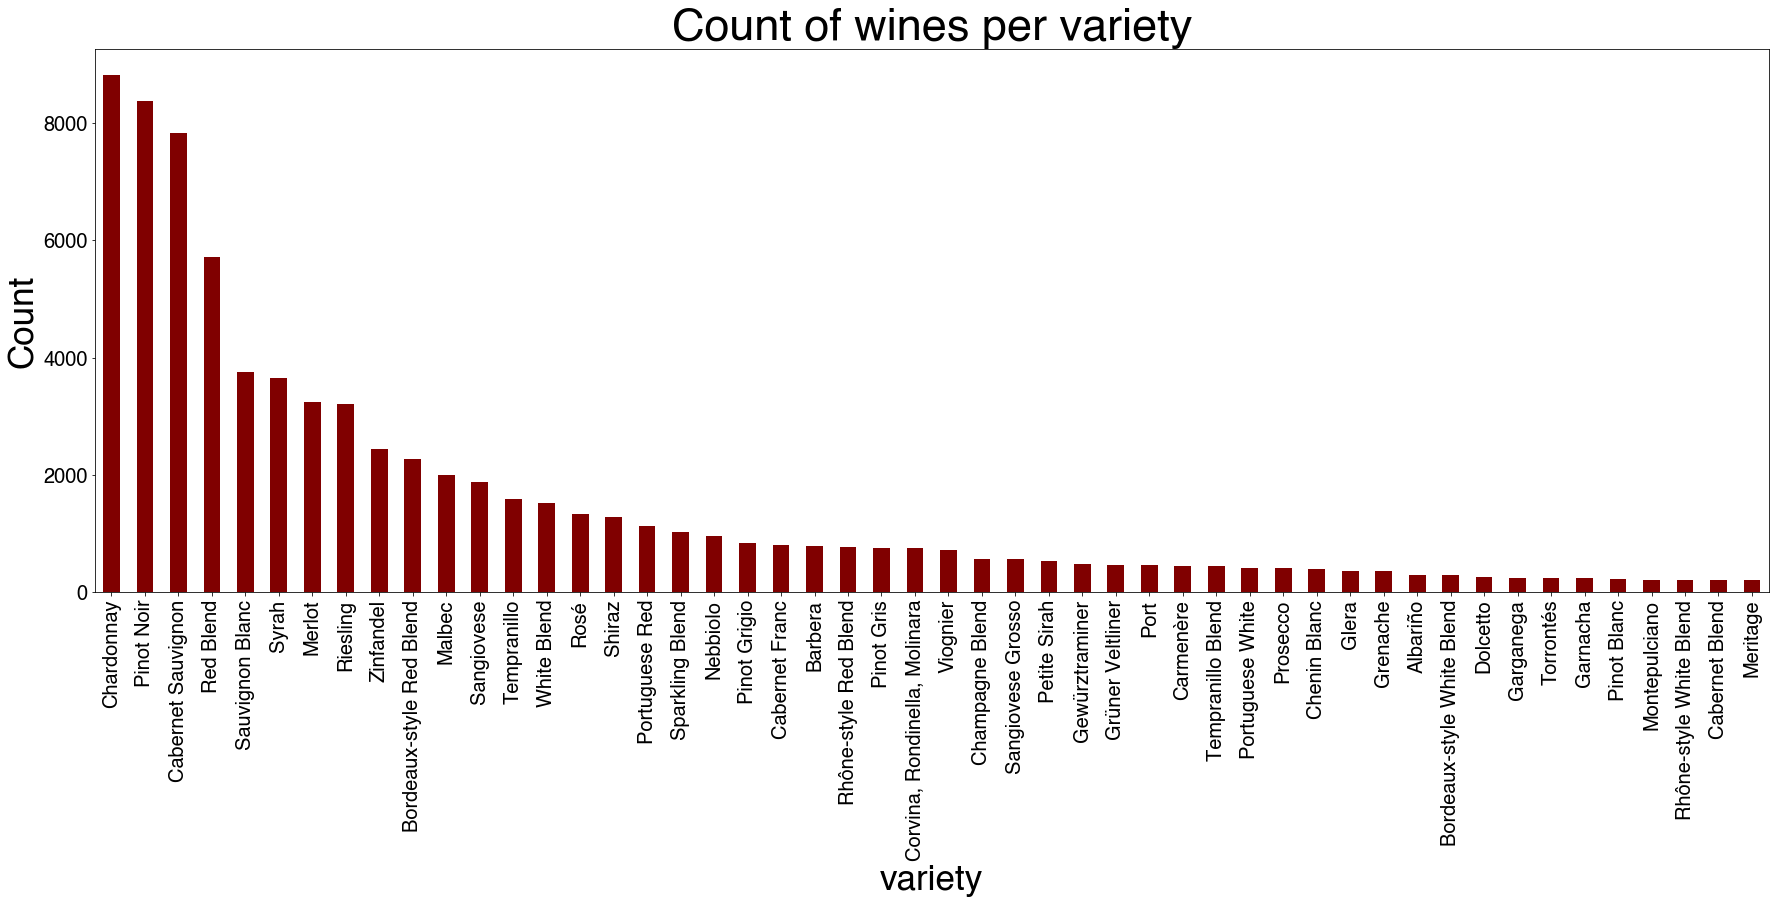

Varieties of wine by percentage (top 10): 
Chardonnay                  10.517977
Pinot Noir                   9.977127
Cabernet Sauvignon           9.335017
Red Blend                    6.817803
Sauvignon Blanc              4.484049
Syrah                        4.345858
Merlot                       3.863382
Riesling                     3.832408
Zinfandel                    2.915108
Bordeaux-style Red Blend     2.706631
Name: variety, dtype: float64


In [21]:

fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Count of wines per variety', fontweight="bold", size=45) # Title
ax.set_ylabel('Count', fontsize = 35) # Y label
ax.set_xlabel('Variety', fontsize = 35) # X label

df.groupby('variety').points.count().sort_values(ascending=False).head(50).plot(kind='bar', color='maroon')
plt.show()

print('Varieties of wine by percentage (top 10): ')
print(df.variety.value_counts(normalize=True).head(10)*100)

Chardonnay is the most common variety of wine in this dataset, making up 10.5% of all the wines.

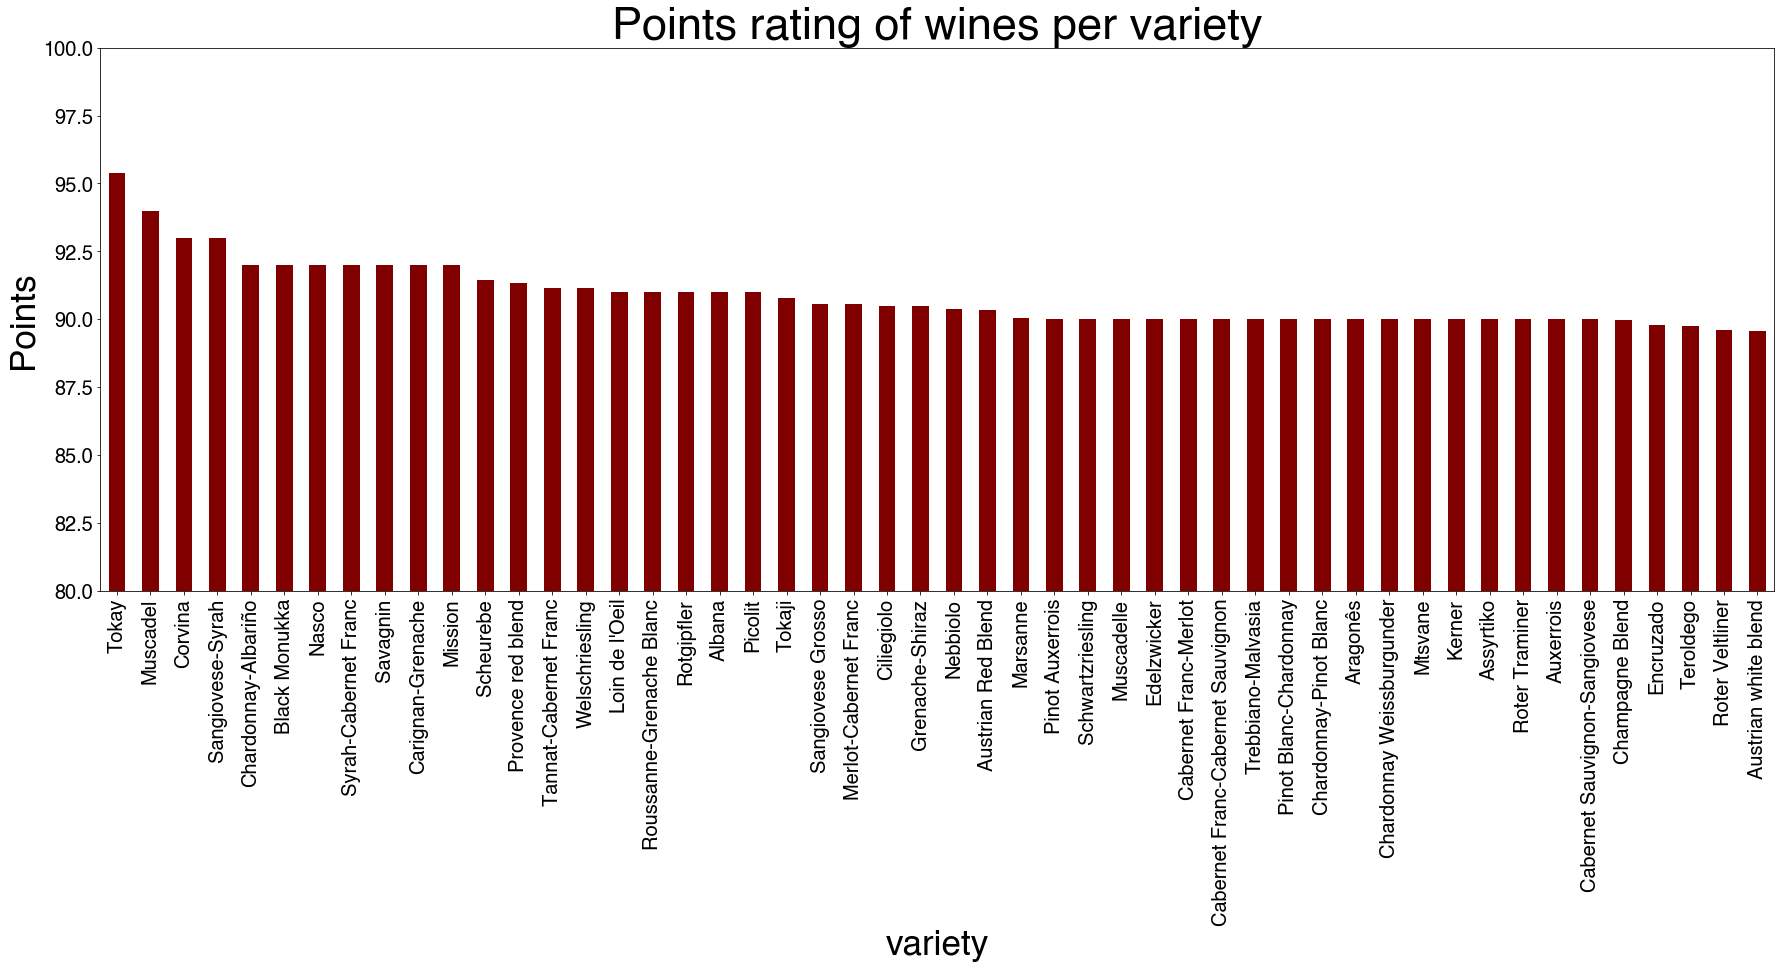

Average rating of wine by variety (top 10): 
variety
Tokay                   95.375
Muscadel                94.000
Corvina                 93.000
Sangiovese-Syrah        93.000
Chardonnay-Albariño     92.000
Black Monukka           92.000
Nasco                   92.000
Syrah-Cabernet Franc    92.000
Savagnin                92.000
Carignan-Grenache       92.000
Name: points, dtype: float64


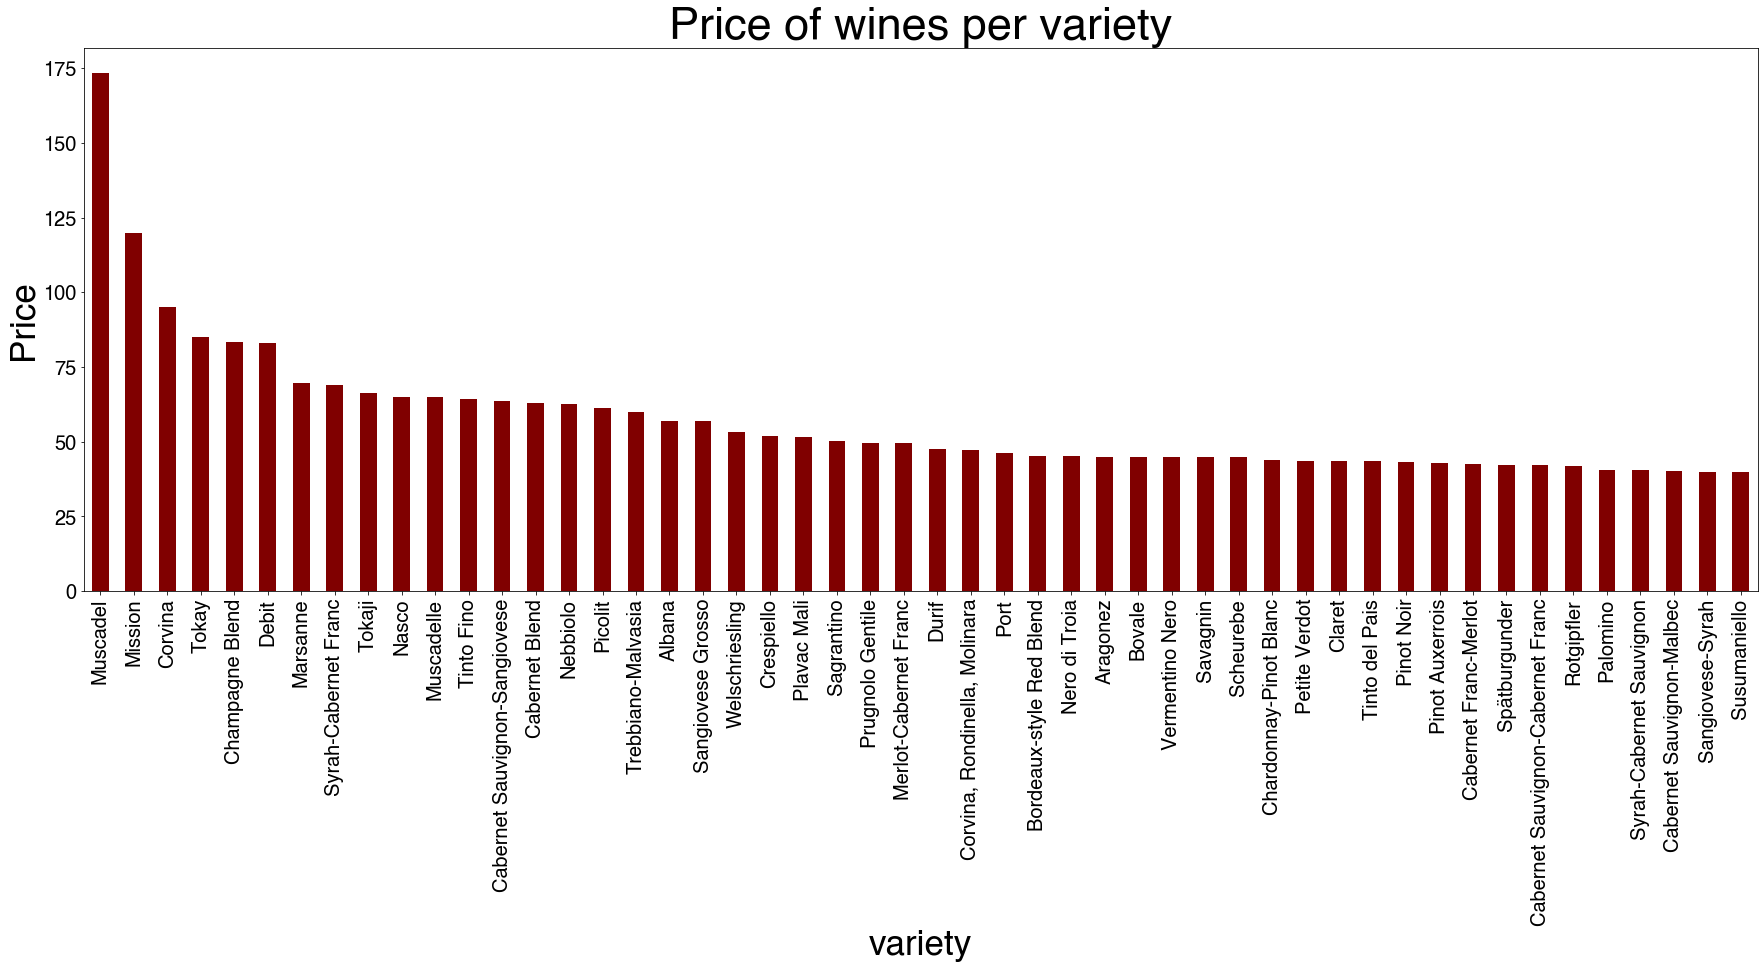

Average price of wine by variety (top 10): 
variety
Muscadel                173.250000
Mission                 120.000000
Corvina                  95.000000
Tokay                    85.125000
Champagne Blend          83.273519
Debit                    83.200000
Marsanne                 69.636364
Syrah-Cabernet Franc     69.000000
Tokaji                   66.420000
Nasco                    65.000000
Name: price, dtype: float64


In [22]:

fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Points rating of wines per variety', fontweight="bold", size=45) # Title
ax.set_ylabel('Points', fontsize = 35) # Y label
ax.set_xlabel('Variety', fontsize = 35) # X label
plt.ylim((80, 100)) 

df.groupby('variety').points.mean().sort_values(ascending=False).head(50).plot(kind='bar', color='maroon')
plt.show()
print('Average rating of wine by variety (top 10): ')
print(df.groupby('variety').points.mean().sort_values(ascending=False).head(10))


fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20) # X Ticks
plt.yticks(fontsize=20) # Y Ticks
ax.set_title('Price of wines per variety', fontweight="bold", size=45) # Title
ax.set_ylabel('Price', fontsize = 35) # Y label
ax.set_xlabel('Variety', fontsize = 35) # X label

df.groupby('variety').price.mean().sort_values(ascending=False).head(50).plot(kind='bar', color='maroon')
plt.show()
print('Average price of wine by variety (top 10): ')
print(df.groupby('variety').price.mean().sort_values(ascending=False).head(10))



While Chardonnay is the most common variety of wine, it is neither the most expensive nor the highest rated wine. Muscadel is the most expensive variety of wine in our dataset, and Tokay is the highest rated. 

### Variable Exploration: Description
- The description of the the wines is what a sommelier says about a particular wine

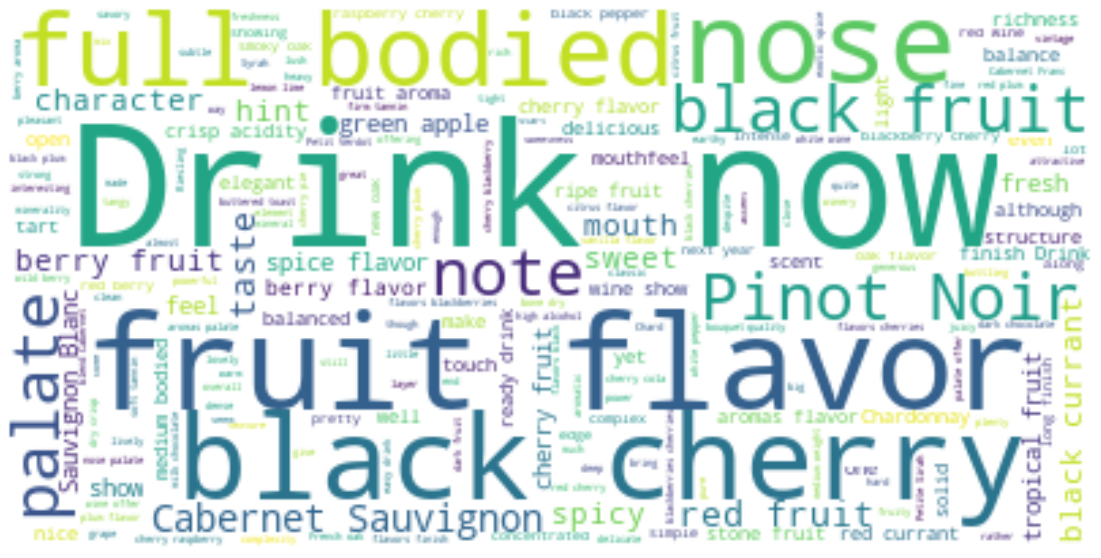

In [23]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = ' '.join(description for description in df.description)

# Generate a word cloud image based on most common words in description:
wordcloud = WordCloud(background_color="white").generate(text)



# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(30, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



## Feature Engineering

In [24]:
# Creating a seperate dataframe to house the features in:
features = pd.DataFrame(df)

In [25]:
features.shape

(83942, 9)

#### Origin feature engineering:
- Because `country`, `province`, `region_1`, and `winery` are hierarchial features and not mutually exclusive, including them all doesn't make sense. In order to reduce dimensionality, we will combine `country` and `province` into a feature called `origin`
    - The variance in the points and prices of wines by region and winery will be captured by the `origin` feature
- The `origin` feature will be composed of the country and province, specifically provinces with at least 100 wines.

In [26]:
# Creating the origin feature by storing the values in a dictionary:
origin = {}

for country in features.country.unique(): # for every country in the dataset,
    for province in features[features.country == country].province: # For every province in that country, 
            if len(features[features.province == province]) > 100: # if that province has more than 100 different wines, 
                origin[province] = '{}: {}'.format(country, province) # assigning the new origin value to the  province key  the syntax is: mydict[key] = "value"
            else:
                origin[province] = '{}: other'.format(country)
                
                
                

In [27]:
features['origin'] = features['province'].replace(origin)

In [28]:
features.head()

,country,description,designation,points,price,province,region_1,variety,winery,origin
0,New Zealand,"Yields were down in 2015, but intensity is up,...",Maté's Vineyard,94,57.0,Kumeu,None,Chardonnay,Kumeu River,New Zealand: other
1,US,This standout Rocks District wine brings earth...,The Funk Estate,94,60.0,Washington,Walla Walla Valley (WA),Syrah,Saviah,US: Washington
2,Argentina,"Concentrated, ripe blackberry and cassis aroma...",The Apple Doesn't Fall Far From The Tree,91,30.0,Mendoza Province,Mendoza,Malbec,Matias Riccitelli,Argentina: Mendoza Province
3,Australia,Moorooduc's estate Pinot Noir is a solid value...,None,91,36.0,Victoria,Mornington Peninsula,Pinot Noir,Moorooduc,Australia: Victoria
4,Argentina,Smoky aromas of fresh-cut wood blend with berr...,Alegoría Gran Reserva,91,25.0,Mendoza Province,Mendoza,Malbec,Navarro Correas,Argentina: Mendoza Province


In [29]:
features.origin.nunique()

112

#### Description length: 
Creating a feature to get the length of each description, as it may help in predicting the points/price of the wine:

In [30]:
features['description_length'] = features.description.apply(len)
features.head()

,country,description,designation,points,price,province,region_1,variety,winery,origin,description_length
0,New Zealand,"Yields were down in 2015, but intensity is up,...",Maté's Vineyard,94,57.0,Kumeu,None,Chardonnay,Kumeu River,New Zealand: other,215
1,US,This standout Rocks District wine brings earth...,The Funk Estate,94,60.0,Washington,Walla Walla Valley (WA),Syrah,Saviah,US: Washington,333
2,Argentina,"Concentrated, ripe blackberry and cassis aroma...",The Apple Doesn't Fall Far From The Tree,91,30.0,Mendoza Province,Mendoza,Malbec,Matias Riccitelli,Argentina: Mendoza Province,242
3,Australia,Moorooduc's estate Pinot Noir is a solid value...,None,91,36.0,Victoria,Mornington Peninsula,Pinot Noir,Moorooduc,Australia: Victoria,315
4,Argentina,Smoky aromas of fresh-cut wood blend with berr...,Alegoría Gran Reserva,91,25.0,Mendoza Province,Mendoza,Malbec,Navarro Correas,Argentina: Mendoza Province,229


Visualizing `description_length`:

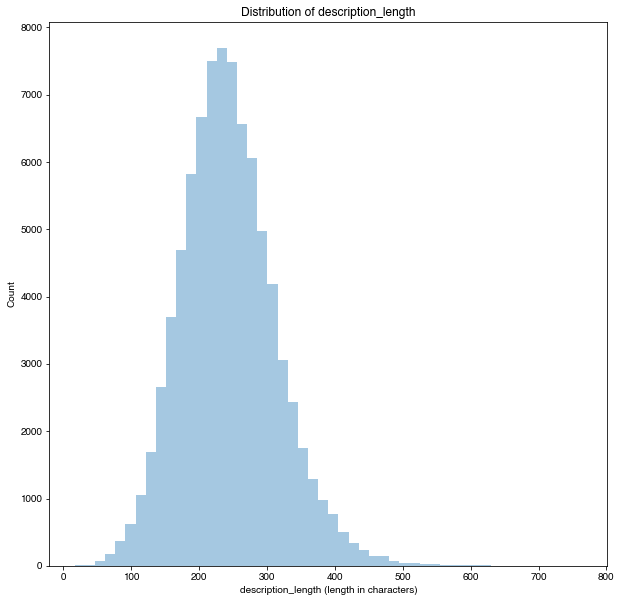

In [31]:
plt.figure(figsize=(10,10))

sns.distplot(features.description_length, kde=False)
plt.title('Distribution of description_length')
plt.xlabel('description_length (length in characters)')
plt.ylabel('Count')
plt.show()

Visualizing `description_length` and its relationship to `price` and `points`

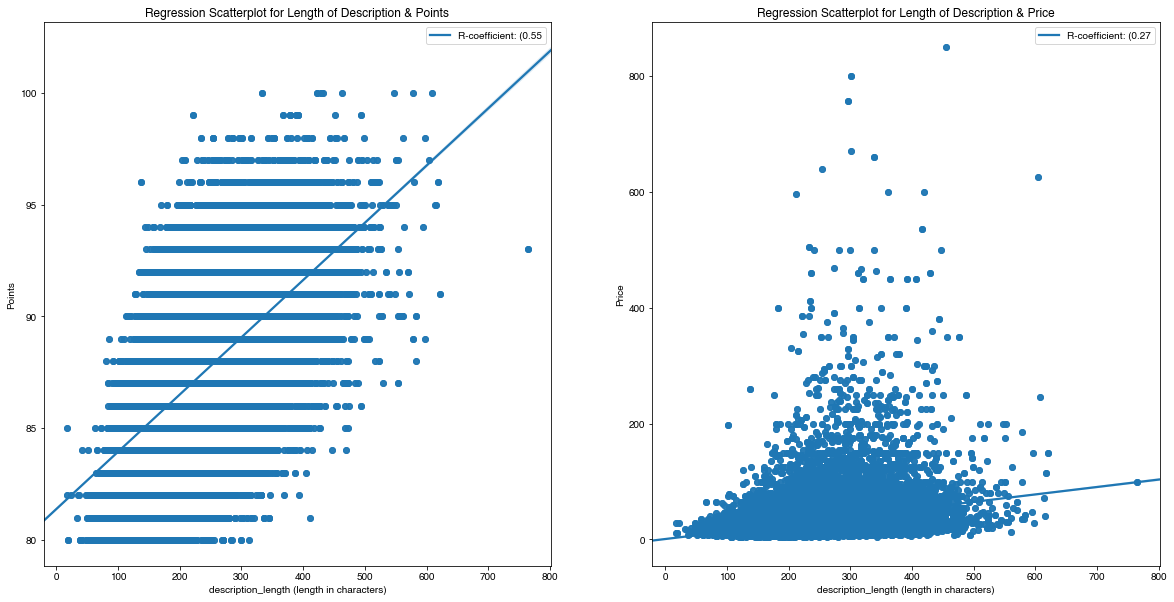

In [32]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
coeff = stats.pearsonr(features.description_length, features.points)

sns.regplot(features.description_length, features.points)
plt.title('Regression Scatterplot for Length of Description & Points')
plt.xlabel('description_length (length in characters)')
plt.ylabel('Points')
plt.legend(['R-coefficient: '+str(coeff)[:5]])

plt.subplot(1,2,2)
coeff = stats.pearsonr(features.description_length, features.price)

sns.regplot(features.description_length, features.price)
plt.title('Regression Scatterplot for Length of Description & Price')
plt.xlabel('description_length (length in characters)')
plt.ylabel('Price')
plt.legend(['R-coefficient: '+str(coeff)[:5]])

plt.show()

In [33]:
features.description_length.describe()

count    83942.000000
mean       243.955576
std         69.744274
min         17.000000
25%        197.000000
50%        240.000000
75%        286.000000
max        764.000000
Name: description_length, dtype: float64

### Analyzing wine descriptions:

#### First, Cleaning up the textual categories: 
- Making all text lower case, removing punctuation, and change characters with diacritic marks to ordinary ASCII format, so that we can get a cleaner, more uniform analysis. 

In [34]:
textual_features = ['description', 'designation', 'province', 'variety']

for feature in textual_features:
    # replace diacritics with ordinary ASCII
    features[feature] = features[feature].apply(lambda x: unidecode.unidecode(x))
    # replace '-' with ' '
    features[feature] = features[feature].str.replace('-', ' ')
    # replace punctuation with ''
    features[feature] = features[feature].str.replace(r'[^a-zA-Z\d\s:]', '')
    # make lower case
    features[feature] = features[feature].str.lower()
    # remove all numbers 
    features[feature] = features[feature].str.replace(r"\d+", "")

#### Removing wine varieties and provinces from the descriptions:
- Because the descriptions may mention the province and wine variety, we need to remove them from the descriptions

In [35]:
# Using value_counts to get a column of all the unique wine varieties:
variety_words = pd.DataFrame(features.variety.value_counts())
# Concatenating all the unique wine varieties, splitting them, and putting them in a set
# the set() will only hold unique words in the list of wine varieties
# so pinot will be a unique word, even if we have two different varieties, like pinot gritio and pinot noir
variety_list = set(variety_words.index.str.cat(sep=' ').split())

# Doing the same thing for the provinces
province_words = pd.DataFrame(features.province.value_counts())
province_list = set(province_words.index.str.cat(sep=" ").split())

print("There are {} unique words that appear in 'variety' that will be taken out of the description".format(len(variety_list)))
print("There are {} unique words that appear in 'province' that will be taken out of the description".format(len(province_list)))



There are 361 unique words that appear in 'variety' that will be taken out of the description
There are 397 unique words that appear in 'province' that will be taken out of the description


Creating a repository of stopwords to remove from the descriptions, manually entering words that are general and vague words that usually precede a more descriptive word that can define a wine review:

In [36]:
# Remove stop words
# Set the stop words
from nltk.corpus import stopwords
from nltk import word_tokenize
extras = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', '{', '}', 'cab',"%", "that's"]
stopwords = set(stopwords.words('english'))
stopwords.update(variety_list)
stopwords.update(province_list)
stopwords.update(extras)
# Updating the stopwords by looking at the common words in the description and removing words that do not contribute meaningfullness
stopwords.update(["drink", "theres", "like", "now", "wine", "flavor", "flavors", "taste", "tastes",
                  "mouth", "nose", "years", "year", "shows", "red", "black", "white",
                  "wines", "reds", "whites", 'price', "also", "which", "note", "notes", "hint",
                  "hints", "feel", "mouth", "nose", "along", "although", "but", "such"
                  
                 ])
# Updating the stopwords after noticing wine years being mentioned in the descriptions:
stopwords.update(['1993','' '2000', '2001', '2002', '2003', '2004', '2005', 
                  '2006', '2007', '2008', '2009', '2010','2011', '2012', '2013', '2014', 
                  '2015','2016', '2017', '2018', '2019', '2020', '2021', '2022','2023', 
                  '2024', '2025', '2030', '100', '10', '12', '14', '15', '20', '25', '30',
                  '40', '50', '60', '70', '90', '01', '02', '03', '04', '05', '06', '07',
                  '08', '09'
                 ])
# Now remove the all the stopwords from the descriptions:
  
features["description"] = features["description"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))




Stopwords removed: 



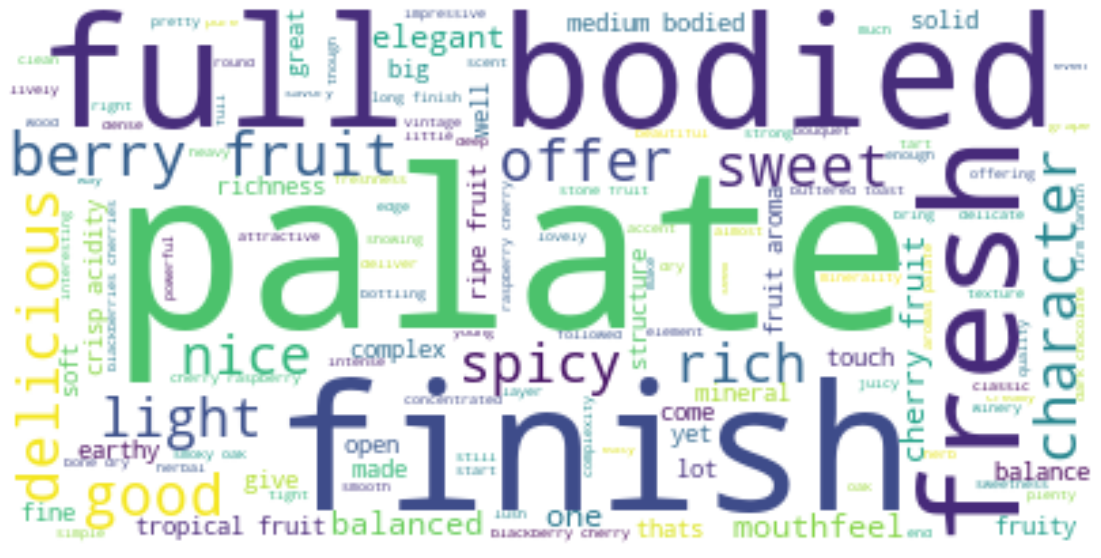

In [37]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

text = ' '.join(description for description in features.description)


wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(text)

print("\nStopwords removed: \n")
# Display the generated image:
# the matplotlib way:
plt.figure(figsize=(30, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [38]:
word_count = len(features.description.str.cat(sep=" ").split())

unique_word_count = pd.DataFrame(features.description.str.cat(sep=" ").split())[0].value_counts().shape[0]

print("There are {} words across all the descriptions, after province names, variety names, words with no bearing on the review's meaning, and common english words.".format(word_count))
print("There are {} unique words across all the descriptions".format(unique_word_count))


There are 1760142 words across all the descriptions, after province names, variety names, words with no bearing on the review's meaning, and common english words.
There are 20662 unique words across all the descriptions


#### Trying TfidfVectorizer
- What is Tf-idf?
    - In this case, Tf-idf is a technique for determining roughly what each description in a set of descriptions is “about”. It accomplishes this by looking at two simple metrics: 
        - **tf (term frequency)** Term frequency is the proportion of occurrences of a specific word to total number of words in a description. 
        - **idf (inverse document frequency)** Inverse document frequency is the inverse of the proportion of descriptions that contain that word/phrase. 
- The general idea is that if specific words appears a lot of times in a given description, but dont appear in many other descriptions, then we have a good idea that those words are important in distinguishing that description, and that wine from all the others. 



In [39]:
features =  features.reset_index(drop=True)

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorizing descriptions:

# min_df indicates the minimum number of documents a word must be in to count – 
# this is a way to avoid counting proper nouns and other words that do not tell us 
# much about a document’s topic

vectorizer = TfidfVectorizer(min_df=50)
vectorizer.fit(features.description)
tfidf_desc = vectorizer.transform(features.description)
tfidf_desc

<83942x3051 sparse matrix of type '<class 'numpy.float64'>'
	with 1590072 stored elements in Compressed Sparse Row format>

#### DImensionality reduction (TF-IDF):
- At this point we have a 83942 x 3051 sparse matrix describing the information contained in the wine's description. Having 3051 features is computationally very taxing. 

- Let's see the impact of TruncatedSVD, a dimension reduction technique similar to PCA but for sparse matrices, on the loss of explained variance. Is it worth it to give up some information for easier computation ?
- What is SVD?
    - The Singular-Value Decomposition, or SVD for short, is a matrix decomposition method for reducing a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler.

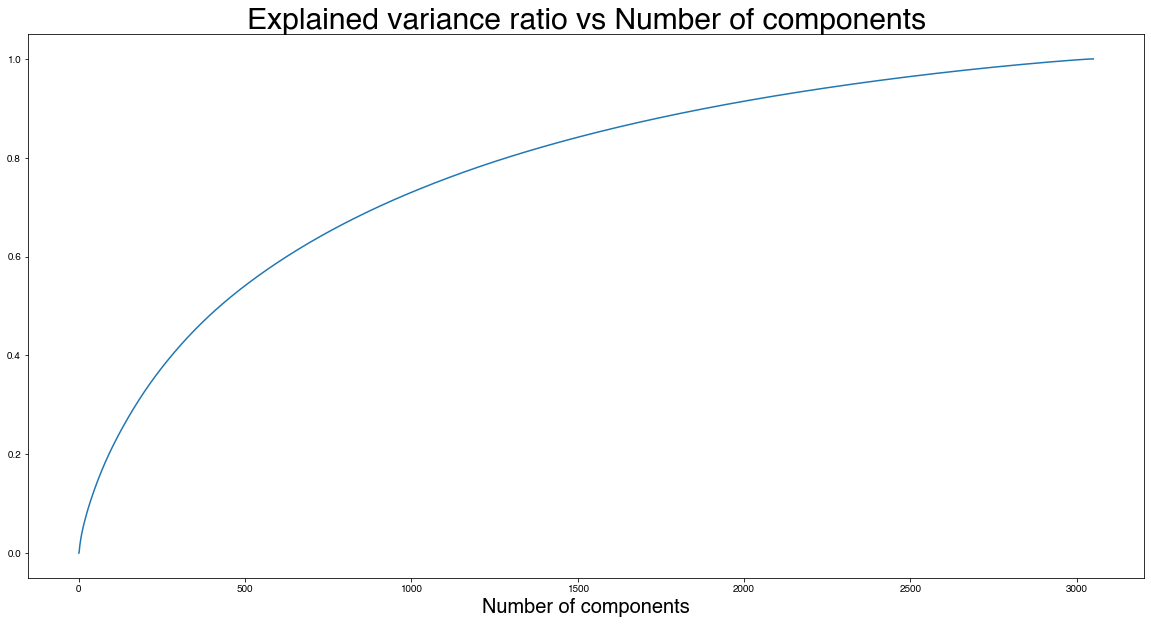

In [41]:
Y_rep = [0] # Will stock the cumulative explained variance ratio of the SVD, 
            # for each n_components
    
# Actual SVD
SVD = TruncatedSVD(n_components=3050)
X_SVD = SVD.fit_transform(tfidf_desc)
var = SVD.explained_variance_ratio_

#This will help us decide on the final number of components we want to keep 
for x in range(3050): 
    Y_rep.append(Y_rep[-1]+var[x])
plt.figure(figsize=(20,10))    
plt.plot(Y_rep)
plt.title("Explained variance ratio vs Number of components", fontsize=30)
plt.xlabel('Number of components', fontsize=20)
plt.ylabel('')

plt.show()

In [42]:
SVD = TruncatedSVD(n_components=1500)
tfidf_reduced = SVD.fit_transform(tfidf_desc)
var = SVD.explained_variance_ratio_
var.sum()

0.8388294535678855

The graph indicates that we can decompose our original 3051 column TF-IDF sparse matrix into 1500 components, while explaining 83.9% of the variance in the original matrix.

Reducing our Description TF-IDF feature size by 50% while only sacrificing 16.1% of the variance in the original feature is a fair tradeoff for better runtimes and manageability when it comes to modeling. 


#### Dimesionality Reduction (Origin and Variety): 
- We have 442 different varieties and 112 different origins for the wines in our feature set
- Using PCA to determine the approprite number of features to reduce our feature combination of origin and varieties for wine:

One-hot-encoding our categorical `origin` and `variety` variables into continous variables for modeling:

In [43]:
origins = pd.get_dummies(features.origin, prefix='origin')

varieties = pd.get_dummies(features.variety, prefix='variety')

origin_variety = pd.concat([origins, varieties], axis=1)

In [44]:
non_description_features = pd.concat([features, origin_variety], axis = 1)
non_description_features = non_description_features.drop(['country', 'description', 'designation', 'province', 'region_1', 'variety', 'winery'], axis=1)

In [45]:
non_desc_corr = non_description_features.corr()

In [46]:
# Creating a list of all origin and variety variables that exhibit high multicollinearity:
# A variable gets added to the list if it has a pearson correlation > 0.5 with any other variable
highcorr = []

for column in non_desc_corr:
    if non_desc_corr[column].sort_values().tolist()[-2] > 0.5:
        highcorr.append(column)

In [47]:
highcorr

['points',
 'description_length',
 'origin_Albania: other',
 'origin_Bosnia and Herzegovina: other',
 'origin_France: Beaujolais',
 'origin_France: Bordeaux',
 'origin_France: Champagne',
 'origin_Georgia: other',
 'origin_Hungary: other',
 'origin_Italy: Piedmont',
 'origin_Italy: Veneto',
 'origin_Japan: other',
 'origin_Macedonia: other',
 'origin_Montenegro: other',
 'origin_Portugal: Port',
 'origin_South Korea: other',
 'origin_Spain: Andalucia',
 'origin_Spain: Galicia',
 'origin_Spain: Levante',
 'origin_Spain: Northern Spain',
 'variety_albarino',
 'variety_blatina',
 'variety_bordeaux style red blend',
 'variety_champagne blend',
 'variety_corvina rondinella molinara',
 'variety_gamay',
 'variety_kallmet',
 'variety_koshu',
 'variety_meoru',
 'variety_monastrell',
 'variety_nebbiolo',
 'variety_port',
 'variety_saperavi',
 'variety_sherry',
 'variety_tempranillo',
 'variety_tokaji',
 'variety_vranec']

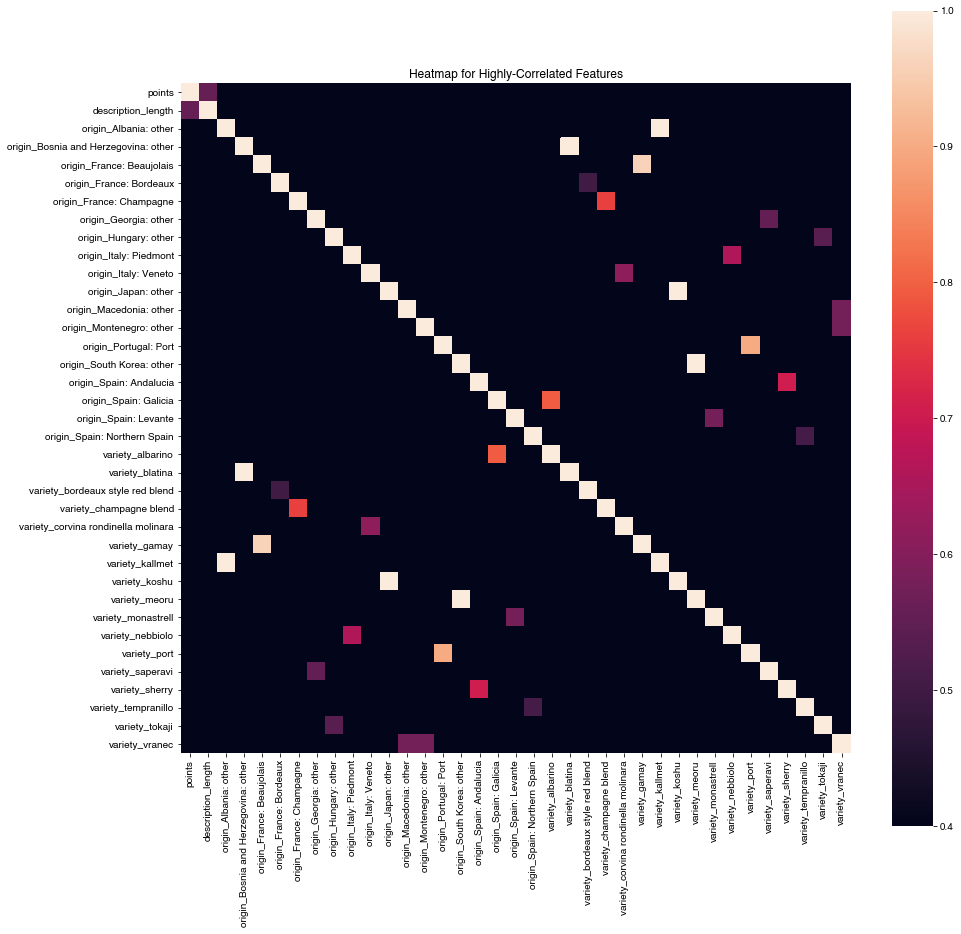

In [48]:
# A correlation matrix of the subset of variables that already exhibit high multicollinearity:
corr = non_description_features[highcorr].corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr, vmin=0.4, square=True)
plt.title('Heatmap for Highly-Correlated Features')
plt.show()

There is collinearity here between origins and varieties, due to wines commonly produced in specific regions. For instance, a wine can only be labeled "Bordeaux" if it's from the Bordeaux region of France, otherwise the same variety of grape would be labeled "Meritage." Similarly, Gamay grapes are used to make wine in Beaujolais, France, and Sangiovese is most commonly produced in Tuscany, Italy. Becuase this is only for a few categories, we will ignore this for now, although further models could implement more stringent filters at this stage.

In [49]:
origin_variety.shape

(83942, 554)

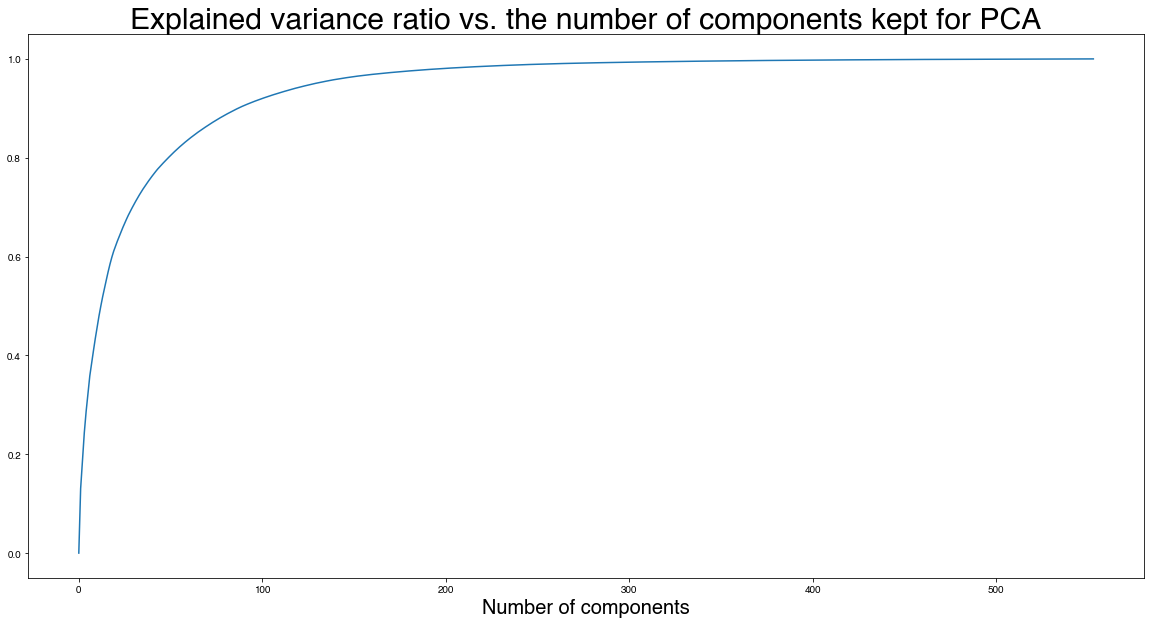

In [50]:
Y_rep = [0] # Will stock the cumulative explained variance ratio of the SVD, 
            # for each n_components
    
# PCA
pca = PCA(n_components=553)
origin_Variety_pca = pca.fit_transform(origin_variety)
pca_var = pca.explained_variance_ratio_

#This will help us decide on the final number of components we want to keep 
for x in range(553): 
    Y_rep.append(Y_rep[-1]+pca_var[x])
    
plt.figure(figsize=(20,10))
plt.plot(Y_rep)
plt.title("Explained variance ratio vs. the number of components kept for PCA", fontweight="bold", size=30)
plt.xlabel('Number of components', fontsize=20)
plt.ylabel('')

plt.show()

In [51]:
pca = PCA(n_components=100)
origin_Variety_pca = pca.fit_transform(origin_variety)
pca_var = pca.explained_variance_ratio_
pca_var.sum()

0.9194876525371771

We can reduce the one-hot encoded combination of origin and variety from 554 to 100 components using PCA, accounting for almost 92% of the variance in the origin and variety data, while removing multicollinearities. 

## Preparing datasets for modeling:



In [52]:
tfidf_reduced = pd.DataFrame(tfidf_reduced)
origin_variety_pca = pd.DataFrame(origin_Variety_pca)

features2 = pd.concat([features, tfidf_reduced, origin_variety_pca], axis=1)
features2 = features2.drop(['description', 'country', 'designation', 'region_1', 'winery', 'province','variety', 'origin'], axis=1)


features2.head()

,points,price,description_length,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,94,57.0,215,0.116228,0.057323,0.001090,0.006004,-0.033671,-0.078709,0.074234,...,-0.000521,-0.012709,-0.003340,-0.012222,-0.007026,0.003120,-0.001188,-0.007964,-0.001961,-0.006254
1,94,60.0,333,0.094332,0.020973,0.049967,0.026527,-0.023274,-0.024780,0.017350,...,-0.000622,-0.002339,-0.000451,0.003082,0.000381,0.000816,-0.001791,0.000765,-0.007042,-0.002981
2,91,30.0,242,0.244494,-0.087650,0.125325,0.014462,0.051066,-0.100107,0.006066,...,0.003228,0.001011,0.000652,0.001203,-0.001679,-0.001839,0.011337,-0.006897,0.005649,0.002861
3,91,36.0,315,0.088699,-0.049204,0.038265,0.001421,-0.020274,0.003372,-0.004968,...,-0.030156,-0.000448,-0.011946,-0.011439,-0.011197,0.003599,0.002402,0.003211,-0.025017,-0.016360
4,91,25.0,229,0.218493,0.028884,0.152262,0.027505,0.007203,-0.046983,-0.079486,...,0.003228,0.001011,0.000652,0.001203,-0.001679,-0.001839,0.011337,-0.006897,0.005649,0.002861


In [53]:
features2.shape

(83942, 1603)

In [60]:
# Pickling our datasets so that we can read them in as objects into a new notebook:

import pickle

features.to_pickle('wine_features.pickle')


features2.to_pickle('wine_features2.pickle')


## Modeling data will be continued on seperate notebook!